## System A: 2-D tomographic system

Consider a simpliﬁed 2-D tomographic system. The
ﬁeld of view (FOV) is a disk of unit radius in the plane. The kernel for the imaging system is given by

\begin{align}
h_m(x,y) = \begin{cases}
1, & \text{for } \left(-1 + \frac{m-1}{16}\right) < y \leq \left(-1 + \frac{m}{16}\right) \\
0, & \text{otherwise}.
\end{cases}
\end{align}

In other words, each sensitivity function is equal to $1$ in a horizontal strip of width $1/16$, and zero outside this strip. The strips are non-overlapping and stack up to cover the whole unit disk. This corresponds to a $32$ pixel detector oriented vertically with perfect collimation. To get the next $32$ sensitivity functions we rotate these by $\pi/16$. We continue rotating by $\pi/16$ to generate a total of $M = 32 \times 16$ sensitivity functions.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Grid size list
grid_size_list = [8, 32, 64, 128]

# Directory for saving results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
# def delete_recursive(directory):
#     for root, dirs, files in os.walk(directory, topdown=False):
#         for name in files:
#             os.remove(os.path.join(root, name))
#         for name in dirs:
#             os.rmdir(os.path.join(root, name))
#     os.rmdir(directory)

models_path = "models"
os.makedirs(models_path, exist_ok=True)

# delete_recursive(output_dir)
base_level_filters = 32
layers = 3

## Part a: Population generation
The first step is to generate a population of objects. Note
here that it is important that there should be variability in your population, else the network may just memorize how to segment the tumor in your training set, and would fail when given a new image with a new tumor.

In [17]:
import datagen

for grid_size in grid_size_list:
    print(f"Generating objects and labels for grid size {grid_size}x{grid_size}.")
    # Create a directory to save the objects and labels, and sigma_s
    object_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "objects")
    labels_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "labels")
    sigma_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "sigma_s")
    os.makedirs(object_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(sigma_dir, exist_ok=True)
    
    # Set the random seed for reproducibility
    random_seed = 42
    np.random.seed(random_seed)

    N = 10
    J = 500  # Number of realizations

    for j in range(J):
        # Generate object and segmentation labels
        f, signal_mask, sigma_s = datagen.generate_object(grid_size, N)
        labels = datagen.generate_segmentation_labels(signal_mask)

        # Save the object and labels, and sigma_s
        np.save(os.path.join(object_dir, f"object_{j}.npy"), f)
        np.save(os.path.join(labels_dir, f"labels_{j}.npy"), labels)
        np.save(os.path.join(sigma_dir, f"labels_{j}.npy"), sigma_s)

        # Optionally print progress
        if (j + 1) % 50 == 0:
            print(f"Saved {j + 1}/{J} realizations.")

    print(f"All {J} realizations have been saved to '{object_dir}'.")

Generating objects and labels for grid size 8x8.
Saved 50/500 realizations.
Saved 100/500 realizations.
Saved 150/500 realizations.
Saved 200/500 realizations.
Saved 250/500 realizations.
Saved 300/500 realizations.
Saved 350/500 realizations.
Saved 400/500 realizations.
Saved 450/500 realizations.
Saved 500/500 realizations.
All 500 realizations have been saved to 'output/8x8/objects'.
Generating objects and labels for grid size 32x32.
Saved 50/500 realizations.
Saved 100/500 realizations.
Saved 150/500 realizations.
Saved 200/500 realizations.
Saved 250/500 realizations.
Saved 300/500 realizations.
Saved 350/500 realizations.
Saved 400/500 realizations.
Saved 450/500 realizations.
Saved 500/500 realizations.
All 500 realizations have been saved to 'output/32x32/objects'.
Generating objects and labels for grid size 64x64.
Saved 50/500 realizations.
Saved 100/500 realizations.
Saved 150/500 realizations.
Saved 200/500 realizations.
Saved 250/500 realizations.
Saved 300/500 realizations

### Visualization

Plotting objects and labels for grid size 8x8.


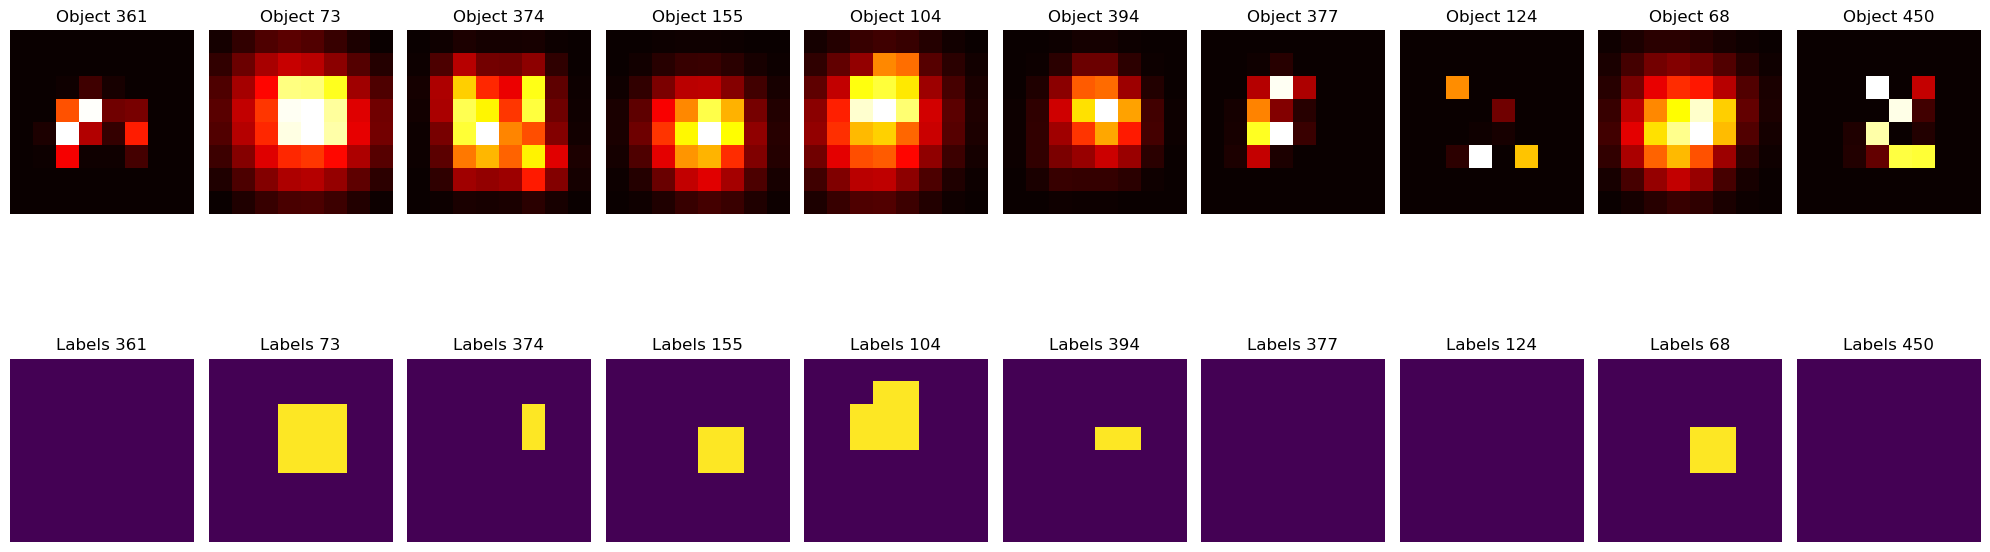

Plotting objects and labels for grid size 32x32.


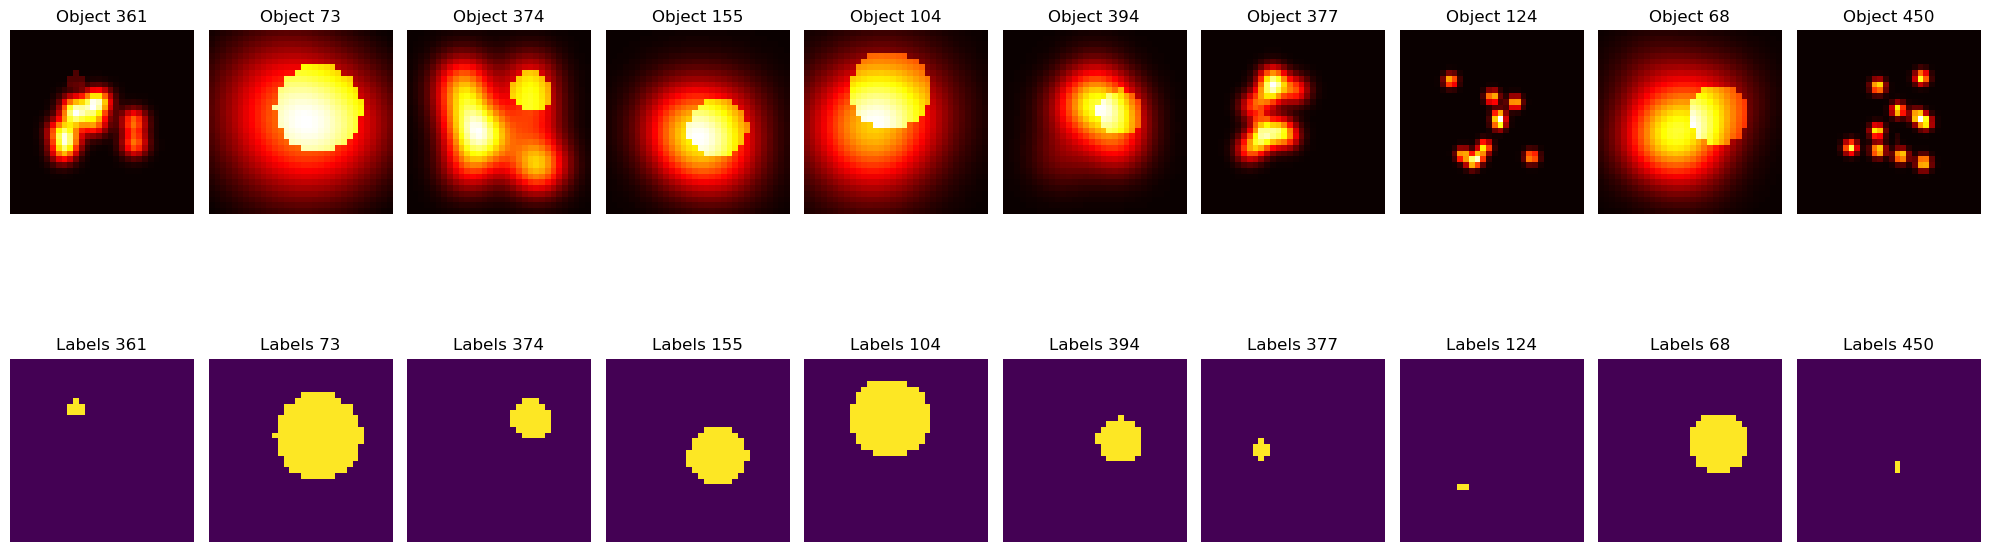

Plotting objects and labels for grid size 64x64.


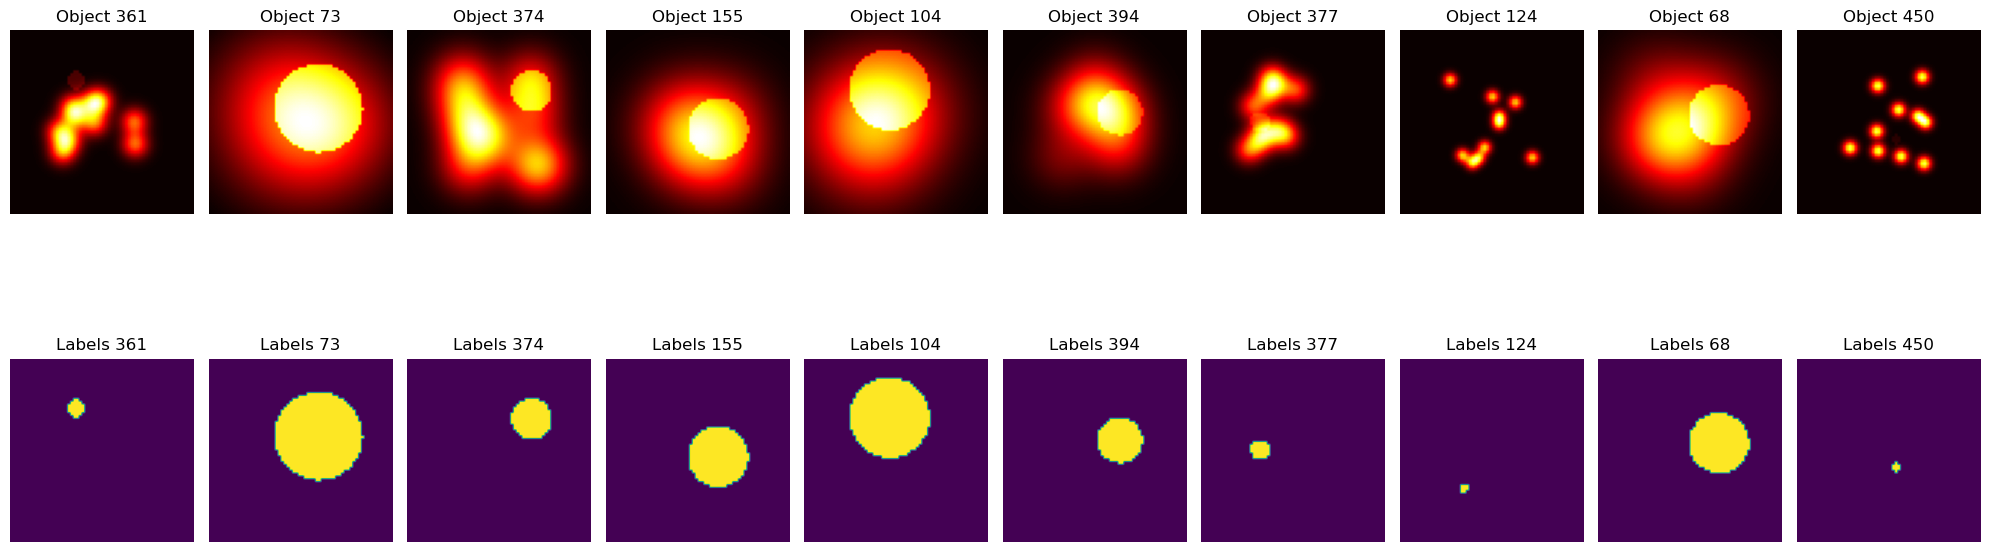

Plotting objects and labels for grid size 128x128.


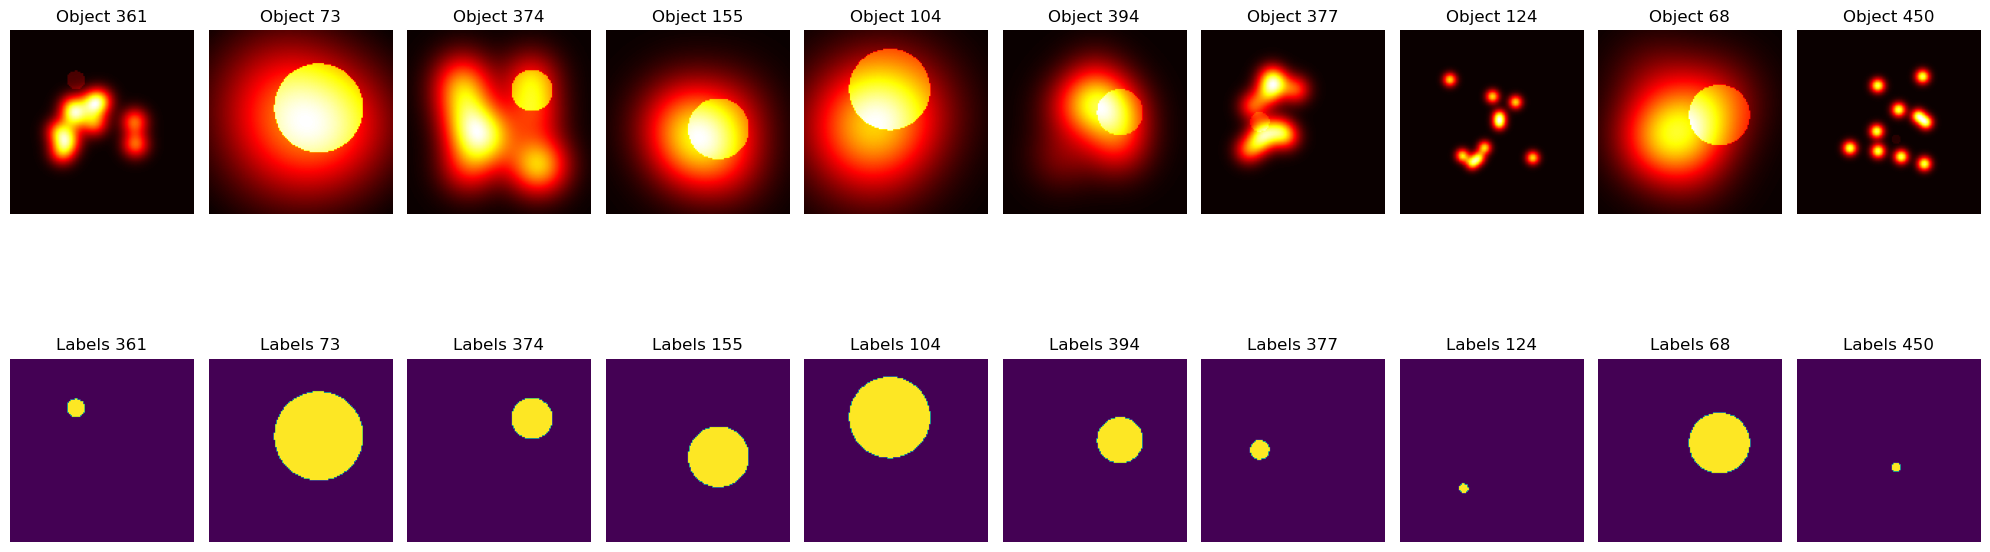

In [3]:
import datagen

for grid_size in grid_size_list:
    print(f"Plotting objects and labels for grid size {grid_size}x{grid_size}.")
    # Create a directory to save the objects and labels
    object_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "objects")
    labels_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "labels")

    object_files = datagen.get_data_files_from_folder(object_dir)
    label_files = datagen.get_data_files_from_folder(labels_dir)

    # Randomly sample 10 indices
    np.random.seed(42)  # Set seed for reproducibility
    sampled_indices = np.random.choice(len(object_files), 10, replace=False)

    # Visualize the sampled objects and labels
    plt.figure(figsize=(20, 8))

    for i, idx in enumerate(sampled_indices):
        # Load object and label
        obj_path = os.path.join(object_dir, object_files[idx])
        lbl_path = os.path.join(labels_dir, label_files[idx])
        obj = np.load(obj_path)
        lbl = np.load(lbl_path)

        # Plot the object
        plt.subplot(2, 10, i + 1)
        plt.imshow(obj, extent=(-1, 1, -1, 1), cmap="hot")
        plt.title(f"Object {idx}")
        plt.axis("off")

        # Plot the segmentation labels
        plt.subplot(2, 10, i + 11)
        plt.imshow(lbl, extent=(-1, 1, -1, 1), cmap="viridis")
        plt.title(f"Labels {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



## Part b: Image generation

Using the imaging system model for System A, conduct
the following:

i. Generate the system matrix: Simulate the forward model for the system using the
expansion function of the object as pixels with the following dimensions: $8 \times 8$, $16 \times 16$, $32 \times 32$, $64 \times 64$.

The kernel for the imaging system is given by

\begin{align}
h_m(x,y) = \begin{cases}
1, & \text{for } \left(-1 + \frac{m-1}{16}\right) < y \leq \left(-1 + \frac{m}{16}\right) \\
0, & \text{otherwise}.
\end{cases}
\end{align}

this is repeated 16 times to get the full set of sensitivity functions, each time rotating by $\pi/16$.

In [4]:
import systema
import os
import numpy as np

for grid_size in grid_size_list:
    print(f"Generating system matrix for grid size {grid_size}x{grid_size}.")
    object_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "objects")
    system_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "system")
    image_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "images")
    reconstruction_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "reconstructions")

    os.makedirs(system_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(object_dir, exist_ok=True)
    os.makedirs(reconstruction_dir, exist_ok=True)

    # Generate H and save
    num_strips = 32
    num_rotations = 16
    H = systema.generate_system_matrix(grid_size, num_strips, num_rotations)
    np.save(os.path.join(system_dir, f"H.npy"), H)
    print(f"System matrix saved as H.npy")

    # Compute and save the pseudo-inverse
    H_pseudo_inv = systema.compute_pseudo_inverse(H)
    np.save(os.path.join(system_dir, f"H_pseudo_inv.npy"), H_pseudo_inv)
    print(f"System matrix saved as H_psuedo_inv.npy")

    # Load and process objects
    object_files = datagen.get_data_files_from_folder(object_dir)
    
    for idx, obj_file in enumerate(object_files):
        obj = np.load(os.path.join(object_dir, obj_file))
        obj_downsampled = systema.downsample_object(obj, grid_size)

        proj = H @ obj_downsampled  # Compute projection data
        rec = H_pseudo_inv @ proj  # Reconstruct the object

        # Save projections and reconstructions by index
        np.save(os.path.join(image_dir, f"image_{idx}.npy"), proj)
        np.save(os.path.join(reconstruction_dir, f"reconstruction_{idx}.npy"), rec)


Generating system matrix for grid size 8x8.
System matrix saved as H.npy
System matrix saved as H_psuedo_inv.npy
Generating system matrix for grid size 32x32.
System matrix saved as H.npy
System matrix saved as H_psuedo_inv.npy
Generating system matrix for grid size 64x64.
System matrix saved as H.npy
System matrix saved as H_psuedo_inv.npy
Generating system matrix for grid size 128x128.
System matrix saved as H.npy
System matrix saved as H_psuedo_inv.npy


Processing grid size 8x8.


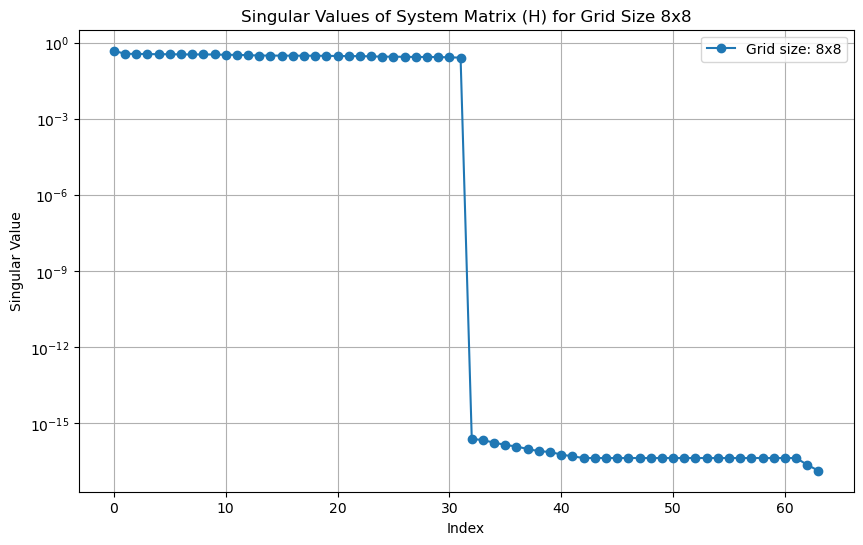

Singular value visualization completed for grid size 8x8.


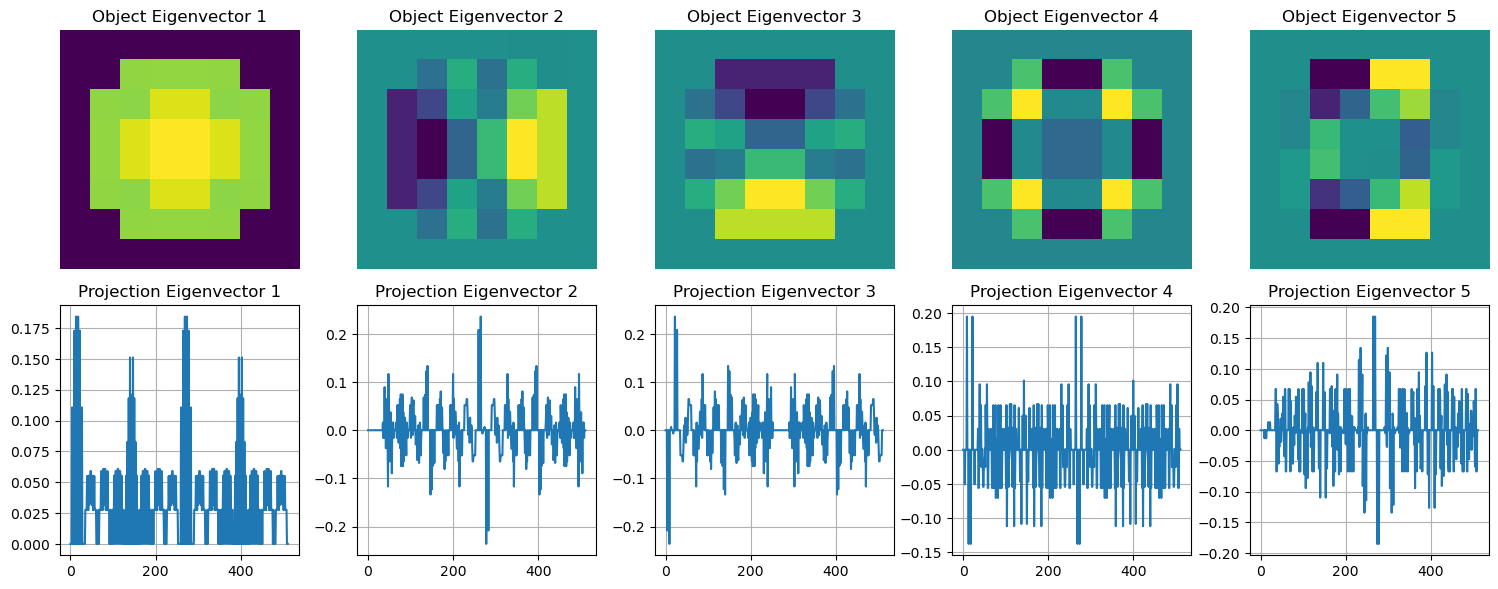

Visualization of top 5 eigenvectors completed for grid size 8x8.
Processing grid size 32x32.


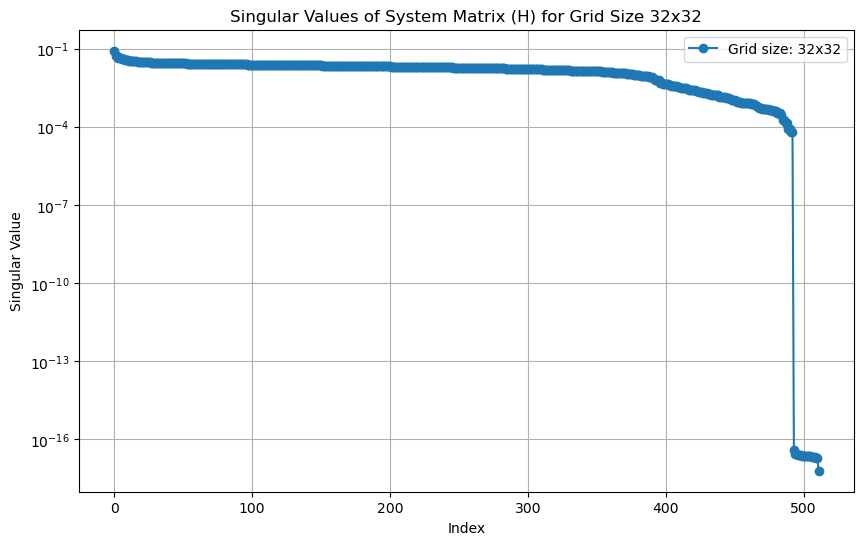

Singular value visualization completed for grid size 32x32.


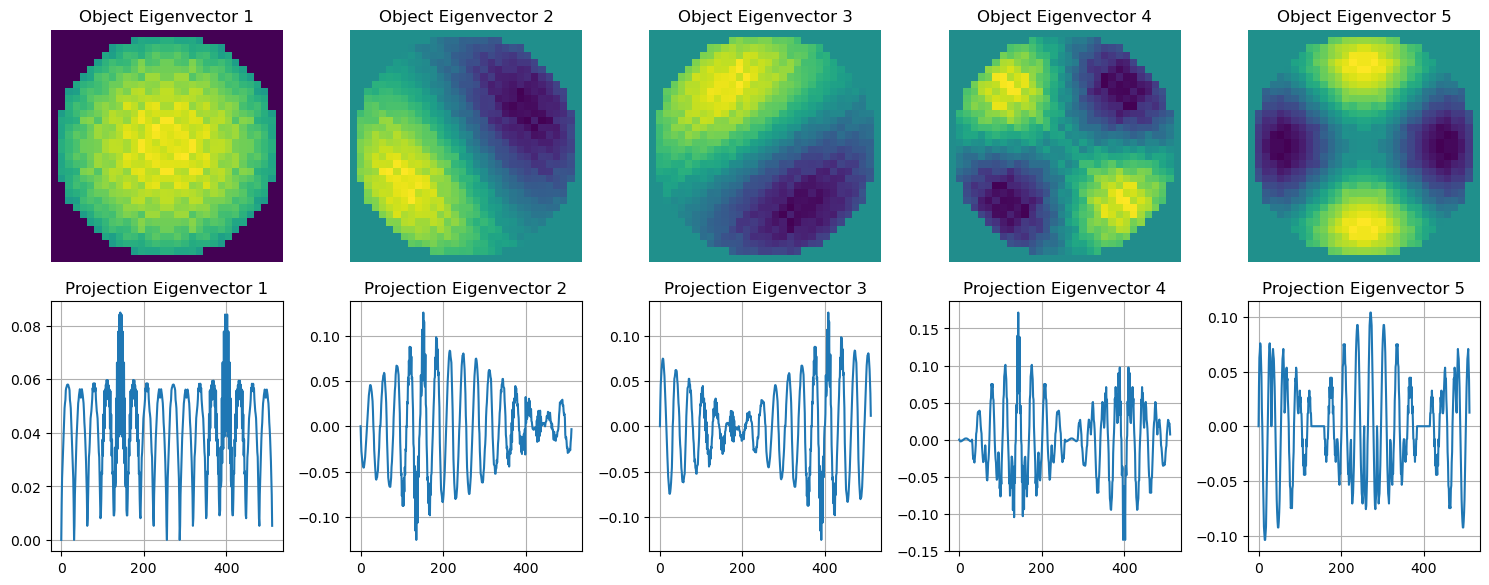

Visualization of top 5 eigenvectors completed for grid size 32x32.
Processing grid size 64x64.


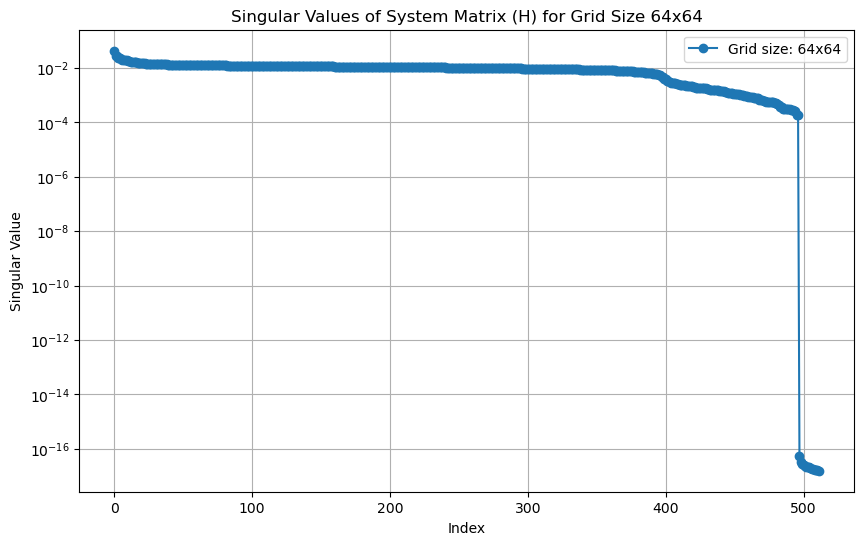

Singular value visualization completed for grid size 64x64.


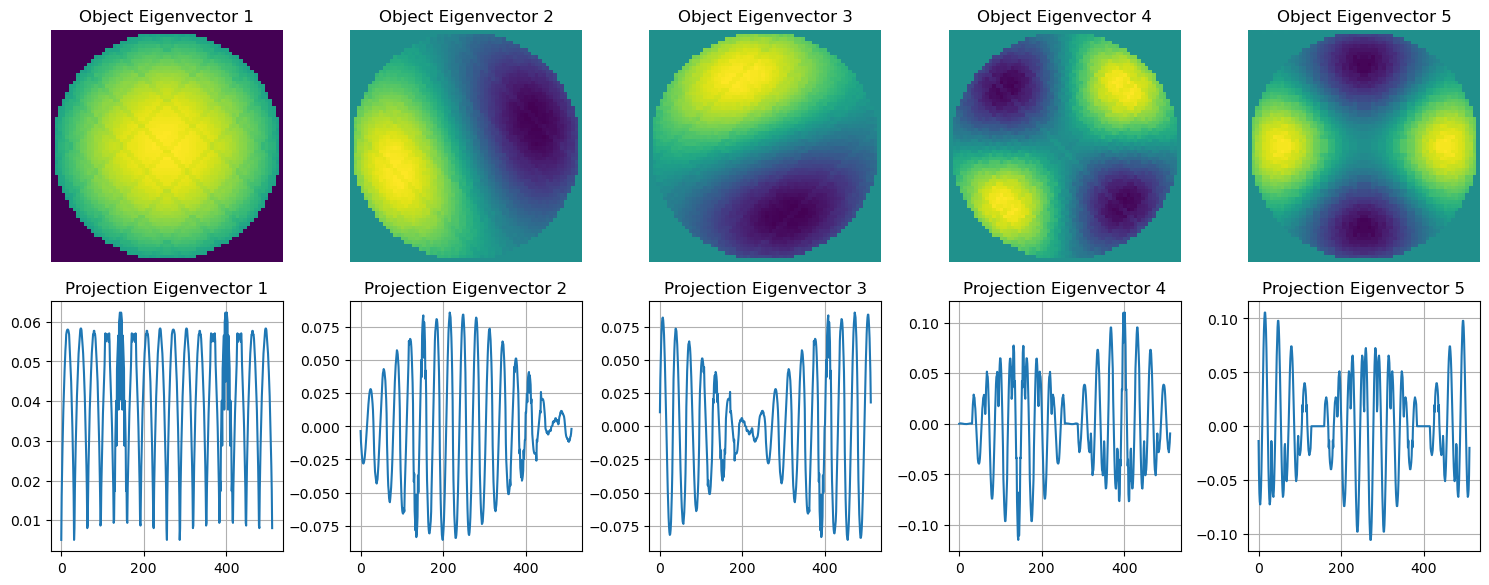

Visualization of top 5 eigenvectors completed for grid size 64x64.
Processing grid size 128x128.


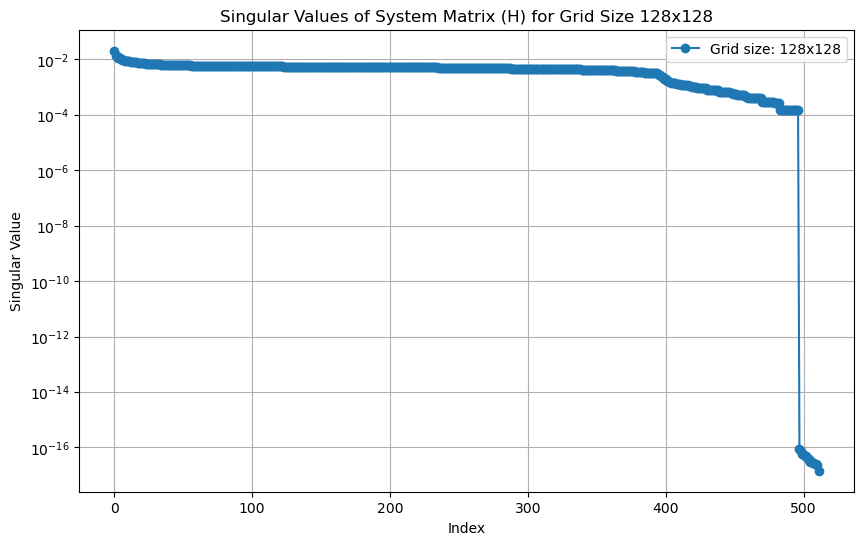

Singular value visualization completed for grid size 128x128.


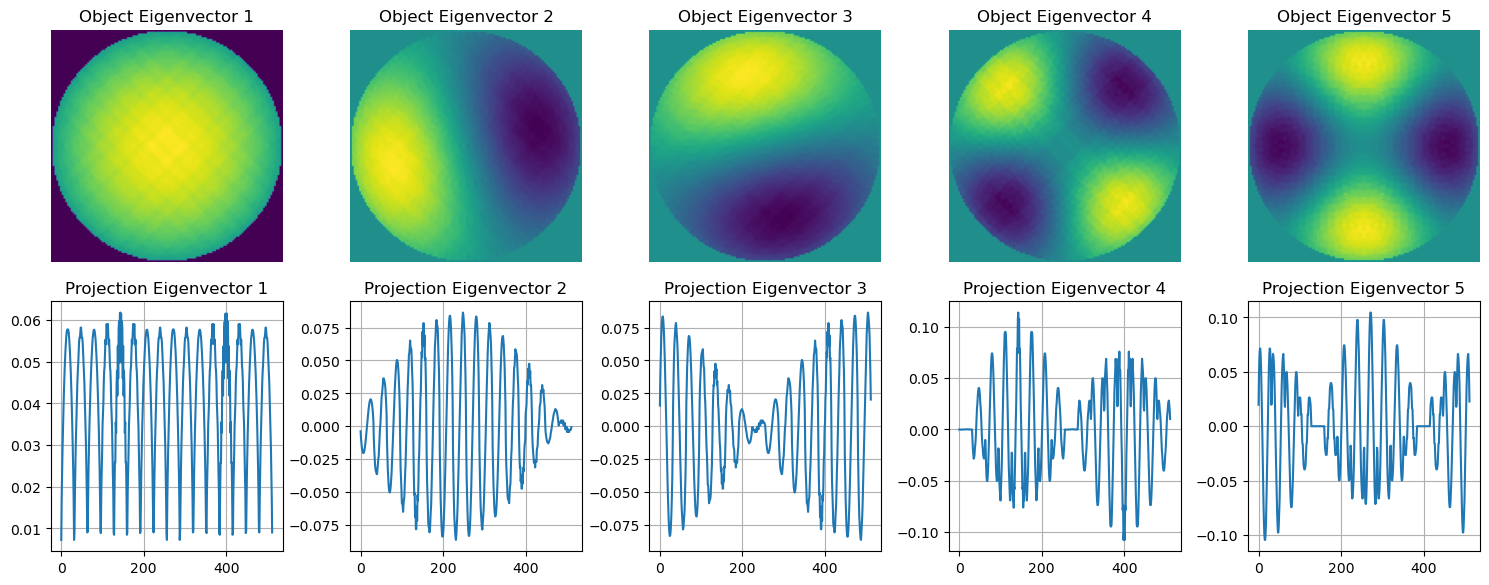

Visualization of top 5 eigenvectors completed for grid size 128x128.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Loop through grid sizes and visualize singular values and eigenvectors
for grid_size in grid_size_list:
    print(f"Processing grid size {grid_size}x{grid_size}.")

    # Load the system matrix H
    system_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "system")
    H_path = os.path.join(system_dir, "H.npy")
    H = np.load(H_path)

    # Compute the SVD of H
    U, S, Vt = np.linalg.svd(H, full_matrices=False)

    # Plot the eigenvalues (singular values)
    plt.figure(figsize=(10, 6))
    plt.plot(S, 'o-', label=f'Grid size: {grid_size}x{grid_size}')
    plt.title(f"Singular Values of System Matrix (H) for Grid Size {grid_size}x{grid_size}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')  # Log scale for better visualization
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Singular value visualization completed for grid size {grid_size}x{grid_size}.")

    # Select the 5 eigenvectors with the largest eigenvalues
    largest_indices = np.argsort(S)[::-1][:5]  # Indices of 5 largest singular values
    U_top = U[:, largest_indices]  # Eigenvectors in projection space
    Vt_top = Vt[largest_indices, :]  # Eigenvectors in object space

    # Reshape eigenvectors in object space for visualization
    grid_side = int(np.sqrt(Vt_top.shape[1]))  # Infer grid size from vector length
    Vt_reshaped = Vt_top.reshape(5, grid_side, grid_side)  # Reshape top 5 eigenvectors

    # Plot eigenvectors in the object space
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(Vt_reshaped[i], extent=(-1, 1, -1, 1), cmap="viridis")
        plt.title(f"Object Eigenvector {i + 1}")
        plt.axis("off")

    # Plot eigenvectors in the projection space
    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.plot(U_top[:, i], label=f"Projection Eigenvector {i + 1}")
        plt.title(f"Projection Eigenvector {i + 1}")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Visualization of top 5 eigenvectors completed for grid size {grid_size}x{grid_size}.")



### Visualize reconstructions

Visualizing reconstructions for grid size 8x8.


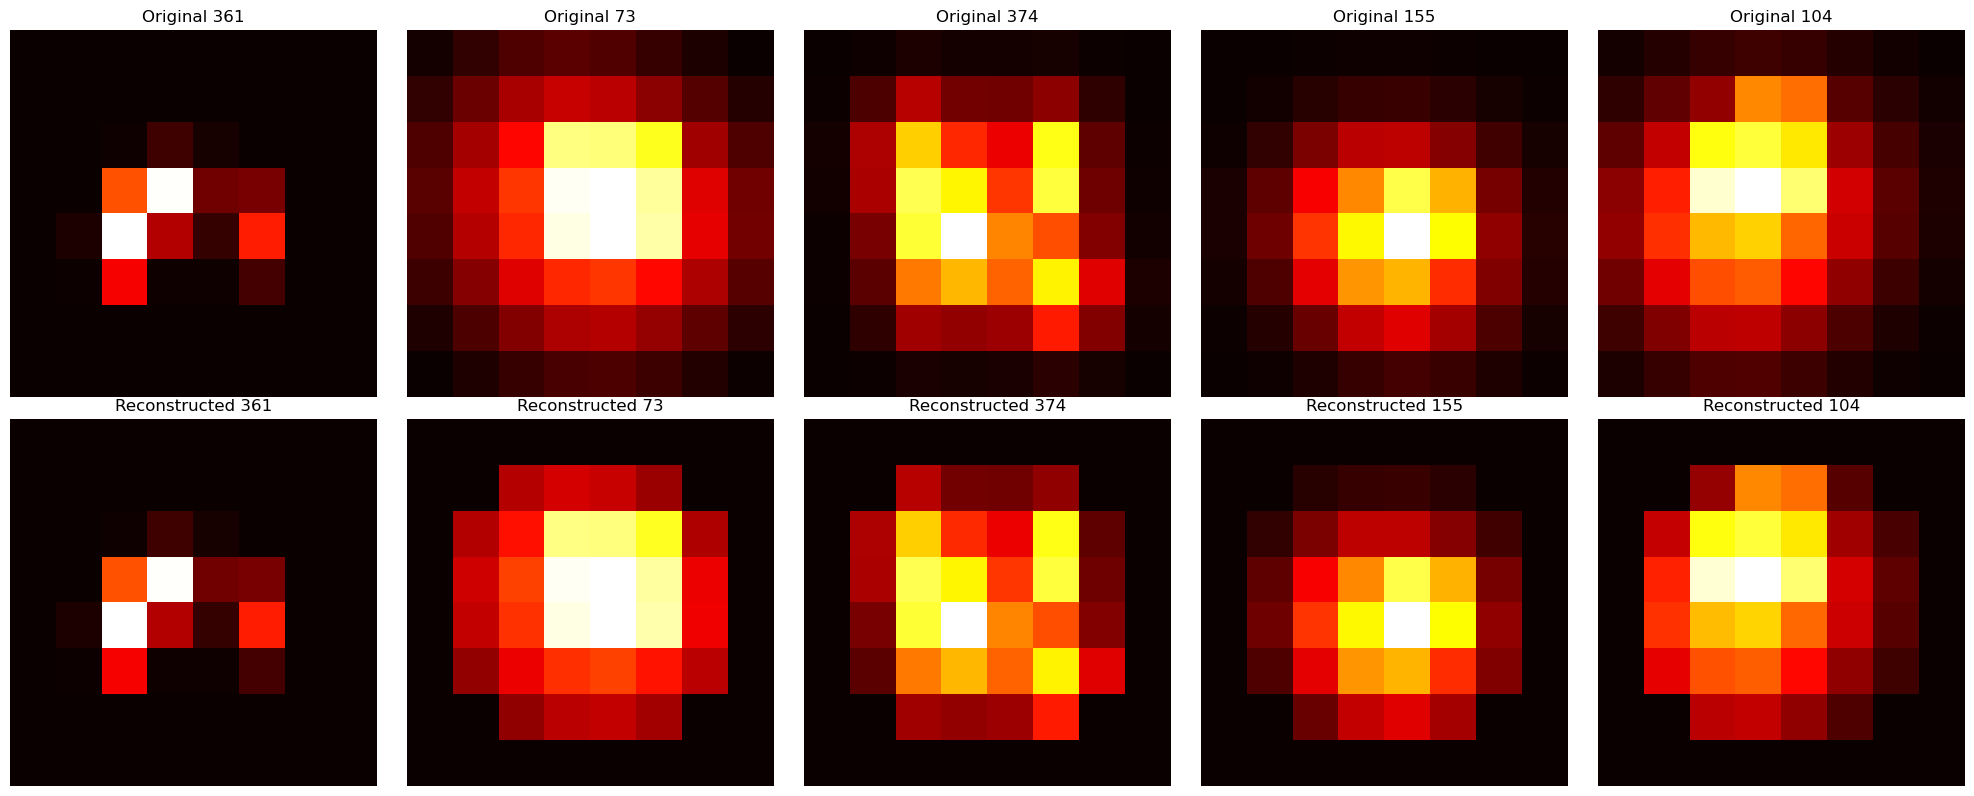

Visualizing reconstructions for grid size 32x32.


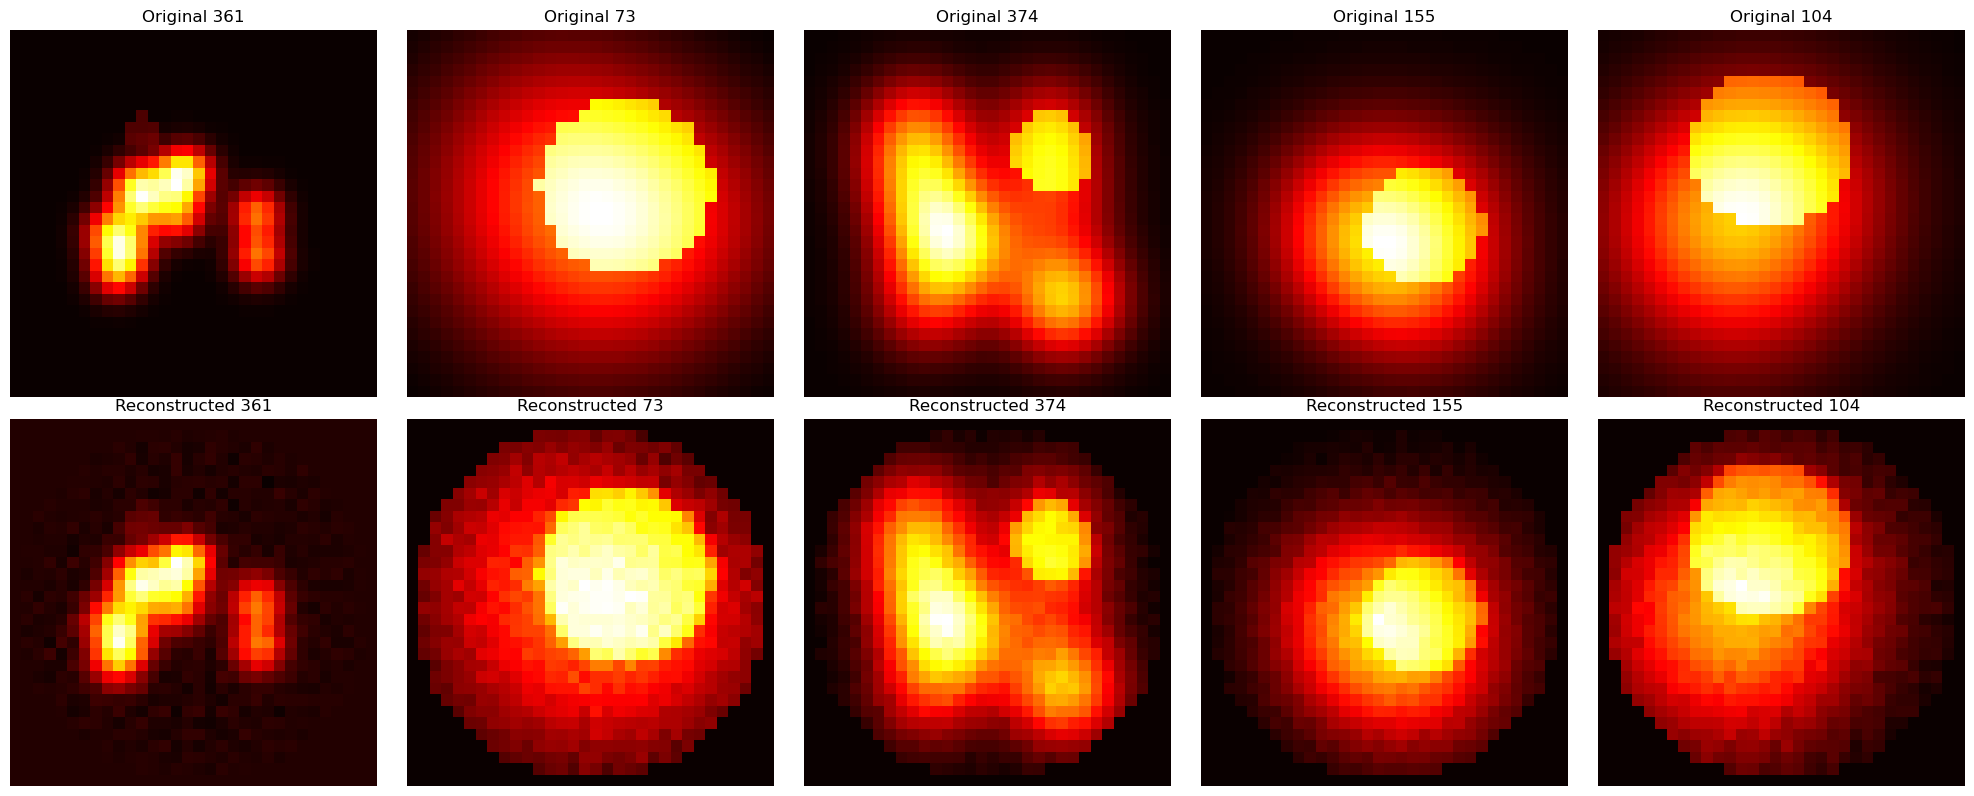

Visualizing reconstructions for grid size 64x64.


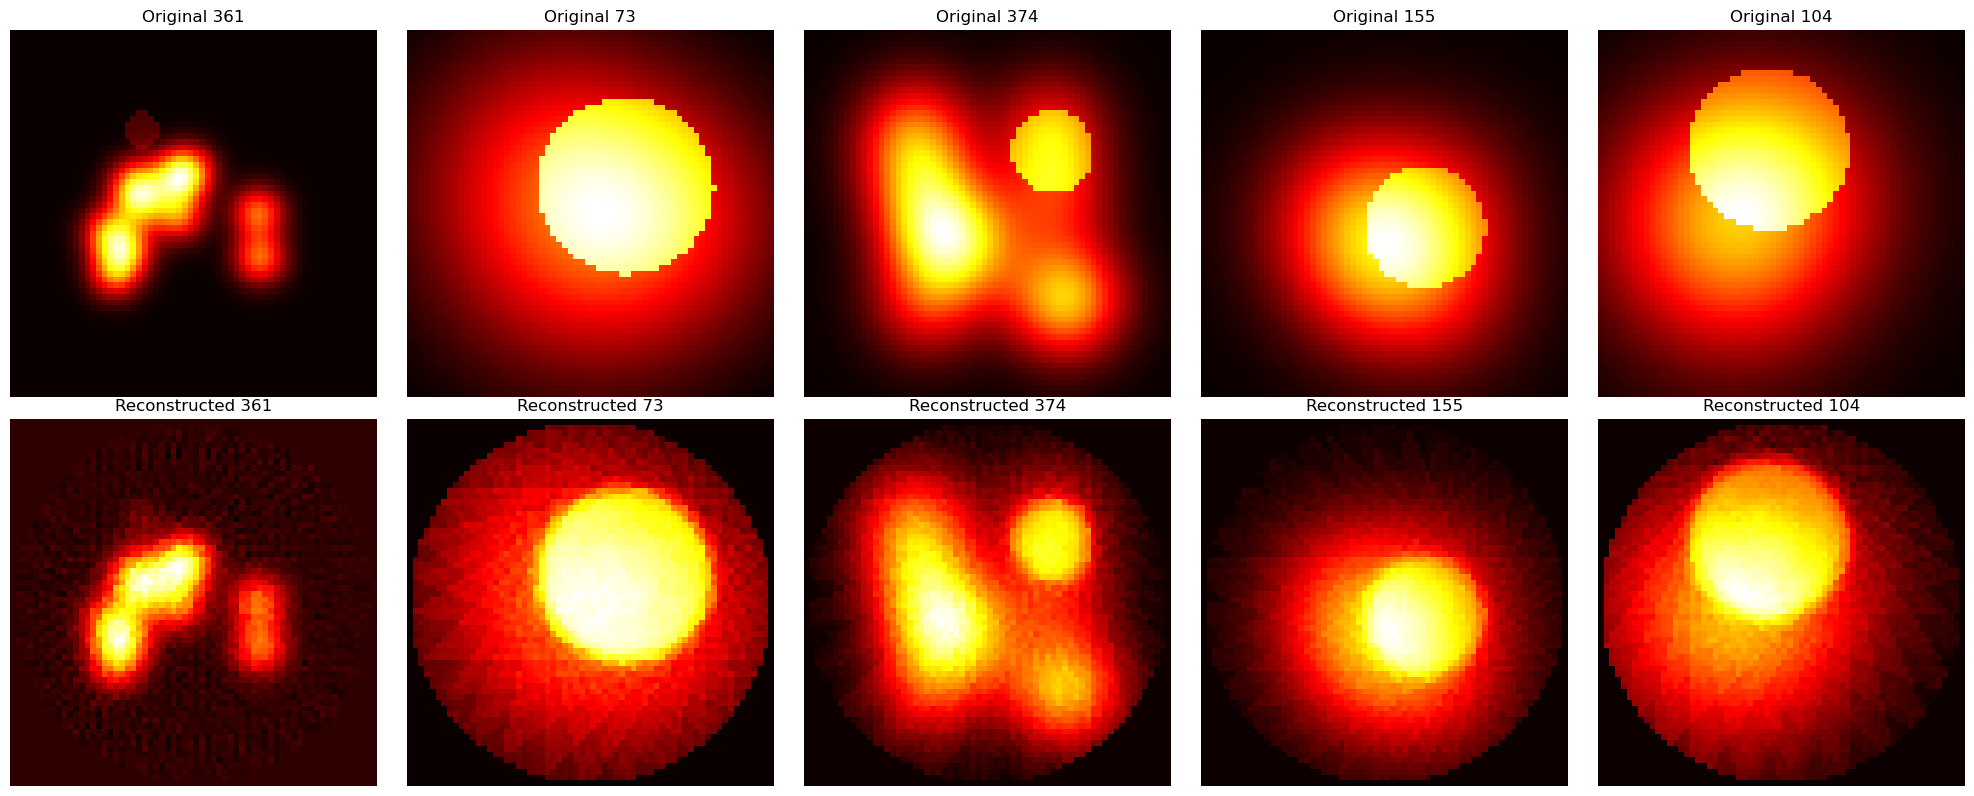

Visualizing reconstructions for grid size 128x128.


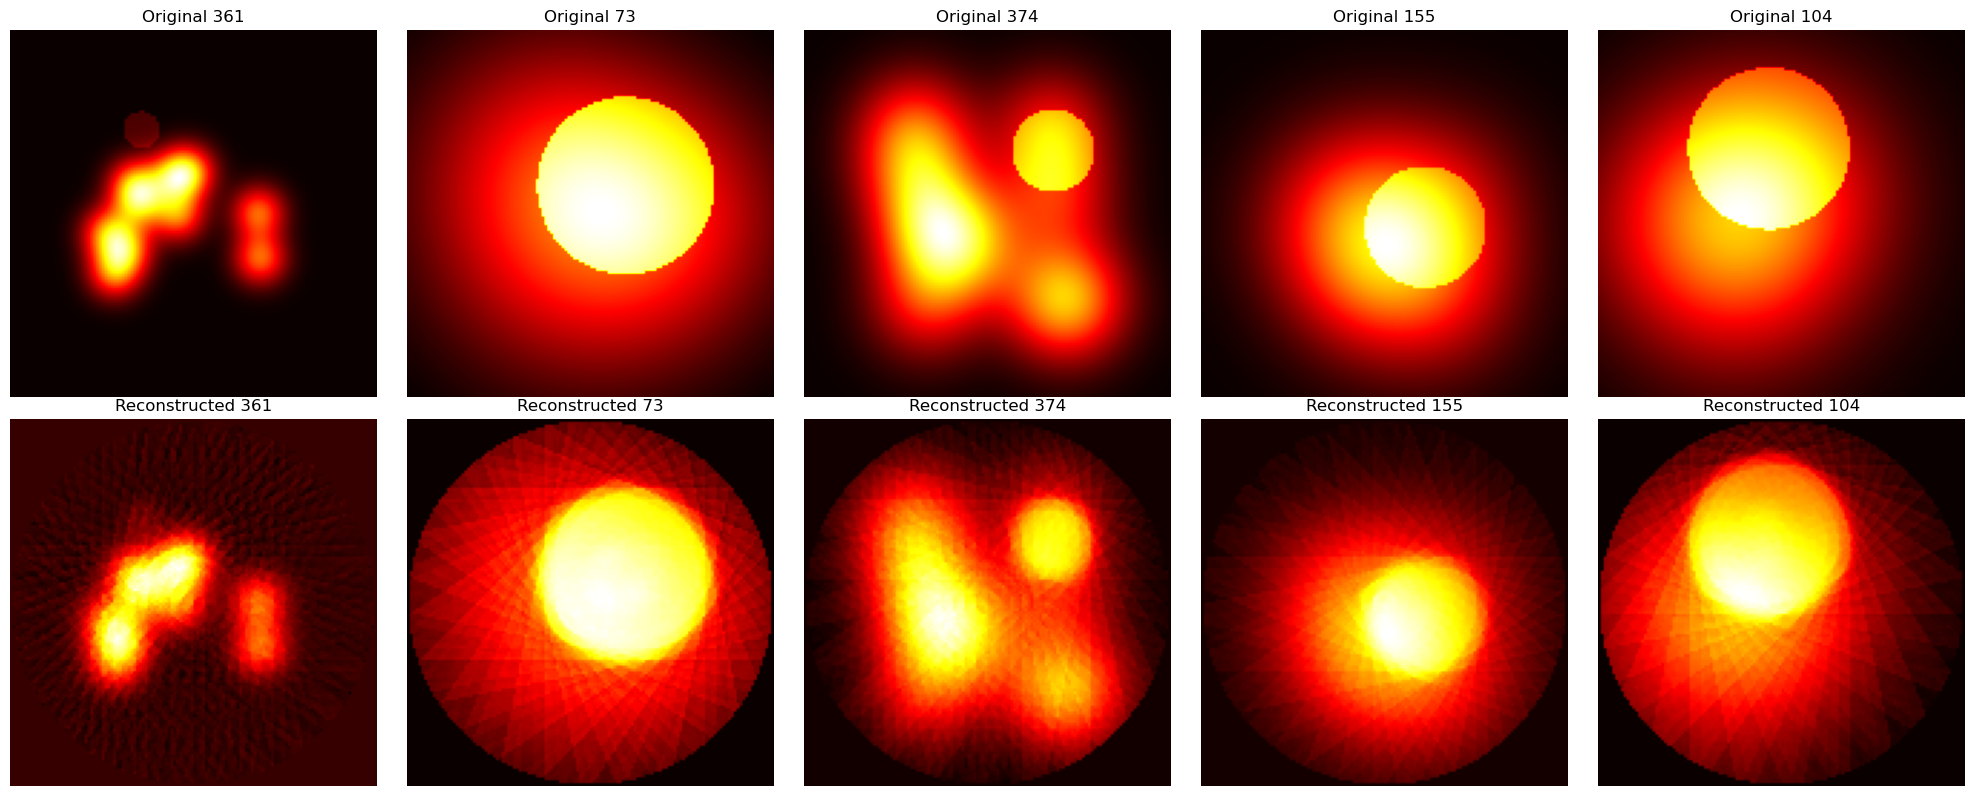

In [6]:
import systema
import os
import numpy as np
import datagen

for grid_size in grid_size_list:
    print(f"Visualizing reconstructions for grid size {grid_size}x{grid_size}.")
    object_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "objects")
    system_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "system")
    image_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "images")
    reconstruction_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}", "reconstructions")

    # Load and process objects
    object_files = datagen.get_data_files_from_folder(object_dir)

    original_objects = []
    reconstructions = []

    for idx, obj_file in enumerate(object_files):
        obj = np.load(os.path.join(object_dir, obj_file))
        obj_downsampled = systema.downsample_object(obj, grid_size)

        proj = np.load(os.path.join(image_dir, f"image_{idx}.npy"))
        rec = np.load(os.path.join(reconstruction_dir, f"reconstruction_{idx}.npy"))

        original_objects.append(obj_downsampled)
        reconstructions.append(rec)

    
    # Set the random seed for reproducibility
    random_seed = 42
    np.random.seed(random_seed)

    # Visualize random samples
    systema.visualize_random_images(grid_size, original_objects, reconstructions, num_to_show=5)



## Part c: Unet training

In [29]:
import unet
import keras

for grid_size in grid_size_list:
    model = unet.unet(input_size=(grid_size, grid_size, 1),num_classes=2,base_level_filters=base_level_filters,layers=layers)
    keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file=f"unet_{grid_size}x{grid_size}.png")
    
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 expand_conv_0_1 (Conv2D)    (None, 8, 8, 32)             320       ['input_46[0][0]']            
                                                                                                  
 expand_conv_0_2 (Conv2D)    (None, 8, 8, 32)             9248      ['expand_conv_0_1[0][0]']     
                                                                                                  
 pool_0 (MaxPooling2D)       (None, 4, 4, 32)             0         ['expand_conv_0_2[0][0]']     
                                                                                              

Training U-Net for grid size 8x8.
500
Epoch 1/20
13/13 [==============================] - 1s 54ms/step - loss: 0.4359 - accuracy: 0.9348 - val_loss: 0.2935 - val_accuracy: 0.9425
Epoch 2/20
13/13 [==============================] - 0s 23ms/step - loss: 0.2267 - accuracy: 0.9472 - val_loss: 0.1685 - val_accuracy: 0.9425
Epoch 3/20
13/13 [==============================] - 0s 18ms/step - loss: 0.1476 - accuracy: 0.9469 - val_loss: 0.1506 - val_accuracy: 0.9425
Epoch 4/20
13/13 [==============================] - 0s 18ms/step - loss: 0.1312 - accuracy: 0.9472 - val_loss: 0.1290 - val_accuracy: 0.9425
Epoch 5/20
13/13 [==============================] - 0s 19ms/step - loss: 0.1202 - accuracy: 0.9478 - val_loss: 0.1228 - val_accuracy: 0.9506
Epoch 6/20
13/13 [==============================] - 0s 19ms/step - loss: 0.1118 - accuracy: 0.9513 - val_loss: 0.1106 - val_accuracy: 0.9584
Epoch 7/20
13/13 [==============================] - 0s 20ms/step - loss: 0.1036 - accuracy: 0.9578 - val_loss: 0.100

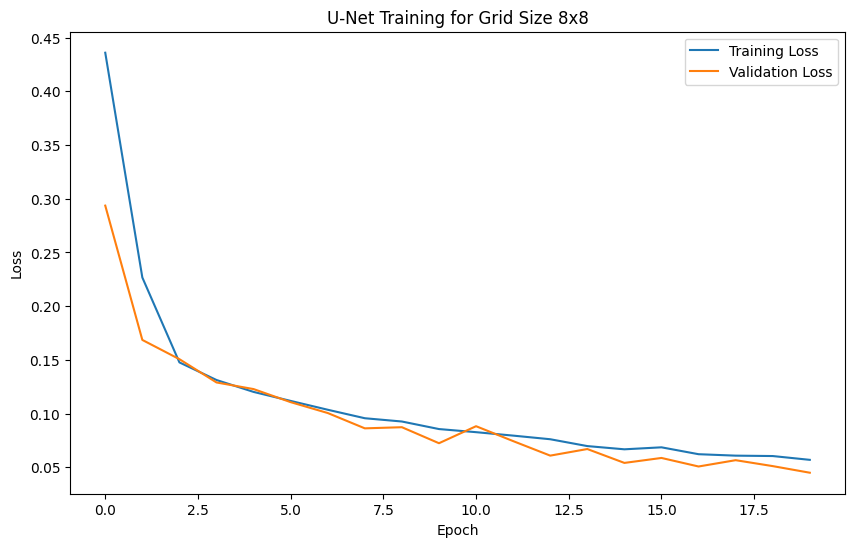

U-Net training completed for grid size 8x8.
Model saved as 'unet_8x8.keras'.
Training U-Net for grid size 32x32.
500
Epoch 1/20
13/13 [==============================] - 2s 117ms/step - loss: 0.5192 - accuracy: 0.8755 - val_loss: 0.3385 - val_accuracy: 0.9282
Epoch 2/20
13/13 [==============================] - 1s 108ms/step - loss: 0.2562 - accuracy: 0.9357 - val_loss: 0.1753 - val_accuracy: 0.9282
Epoch 3/20
13/13 [==============================] - 1s 107ms/step - loss: 0.1574 - accuracy: 0.9357 - val_loss: 0.1587 - val_accuracy: 0.9282
Epoch 4/20
13/13 [==============================] - 1s 103ms/step - loss: 0.1383 - accuracy: 0.9357 - val_loss: 0.1350 - val_accuracy: 0.9282
Epoch 5/20
13/13 [==============================] - 1s 108ms/step - loss: 0.1230 - accuracy: 0.9357 - val_loss: 0.1166 - val_accuracy: 0.9282
Epoch 6/20
13/13 [==============================] - 1s 107ms/step - loss: 0.1120 - accuracy: 0.9357 - val_loss: 0.1083 - val_accuracy: 0.9282
Epoch 7/20
13/13 [=============

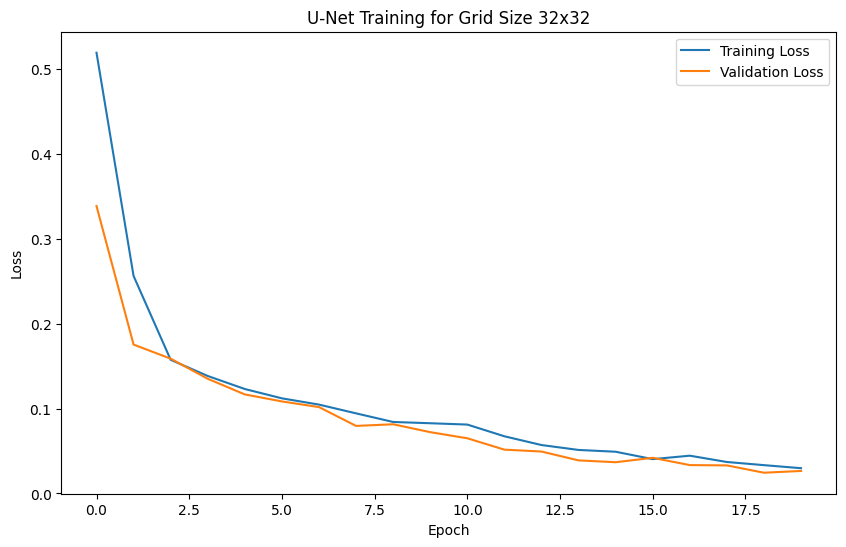

U-Net training completed for grid size 32x32.
Model saved as 'unet_32x32.keras'.
Training U-Net for grid size 64x64.
500
Epoch 1/20
13/13 [==============================] - 5s 385ms/step - loss: 0.4952 - accuracy: 0.8885 - val_loss: 0.2858 - val_accuracy: 0.9260
Epoch 2/20
13/13 [==============================] - 5s 370ms/step - loss: 0.1849 - accuracy: 0.9336 - val_loss: 0.1571 - val_accuracy: 0.9260
Epoch 3/20
13/13 [==============================] - 5s 366ms/step - loss: 0.1382 - accuracy: 0.9336 - val_loss: 0.1347 - val_accuracy: 0.9260
Epoch 4/20
13/13 [==============================] - 5s 358ms/step - loss: 0.1269 - accuracy: 0.9336 - val_loss: 0.1312 - val_accuracy: 0.9260
Epoch 5/20
13/13 [==============================] - 5s 356ms/step - loss: 0.1198 - accuracy: 0.9336 - val_loss: 0.1130 - val_accuracy: 0.9260
Epoch 6/20
13/13 [==============================] - 5s 356ms/step - loss: 0.1184 - accuracy: 0.9336 - val_loss: 0.1141 - val_accuracy: 0.9260
Epoch 7/20
13/13 [=========

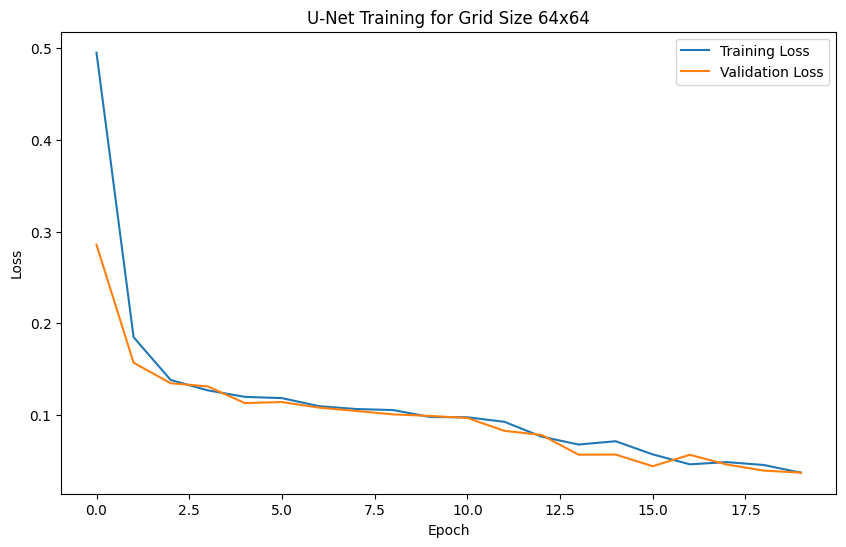

U-Net training completed for grid size 64x64.
Model saved as 'unet_64x64.keras'.
Training U-Net for grid size 128x128.
500
Epoch 1/20
13/13 [==============================] - 20s 1s/step - loss: 0.5408 - accuracy: 0.8668 - val_loss: 0.3264 - val_accuracy: 0.9248
Epoch 2/20
13/13 [==============================] - 20s 2s/step - loss: 0.1999 - accuracy: 0.9325 - val_loss: 0.1570 - val_accuracy: 0.9248
Epoch 3/20
13/13 [==============================] - 19s 1s/step - loss: 0.1371 - accuracy: 0.9325 - val_loss: 0.1355 - val_accuracy: 0.9248
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.1292 - accuracy: 0.9325 - val_loss: 0.1300 - val_accuracy: 0.9248
Epoch 5/20
13/13 [==============================] - 20s 2s/step - loss: 0.1244 - accuracy: 0.9325 - val_loss: 0.1241 - val_accuracy: 0.9248
Epoch 6/20
13/13 [==============================] - 19s 1s/step - loss: 0.1175 - accuracy: 0.9401 - val_loss: 0.1077 - val_accuracy: 0.9543
Epoch 7/20
13/13 [===================

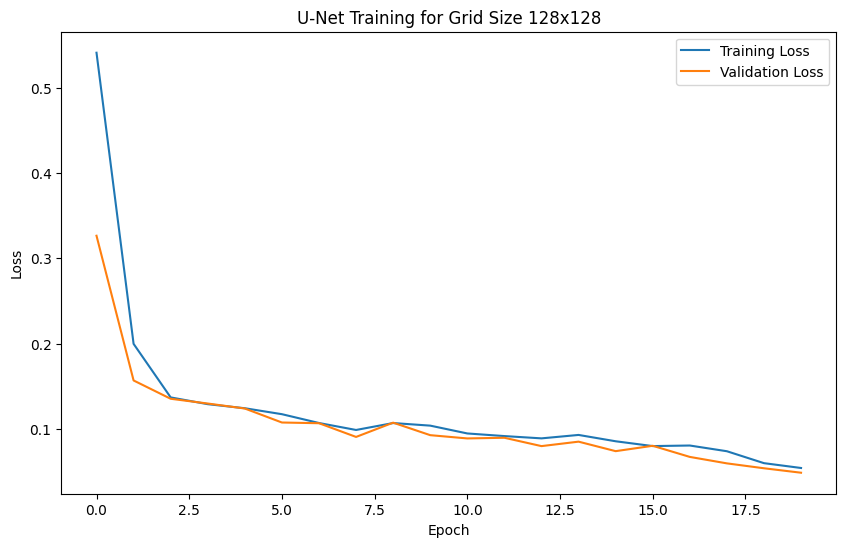

U-Net training completed for grid size 128x128.
Model saved as 'unet_128x128.keras'.


In [12]:
import unet

for grid_size in grid_size_list:
    print(f"Training U-Net for grid size {grid_size}x{grid_size}.")
    data_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}")
    data = unet.get_data(data_dir, grid_size)
    model = unet.unet(input_size=(grid_size, grid_size, 1),num_classes=2,base_level_filters=base_level_filters,layers=layers) #unet model specifications
    
    x_test, x_train, y_test, y_train = unet.data_split(data)
    r = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20)
    model.save(os.path.join(models_path, f"unet_{grid_size}x{grid_size}.keras"))

    # Plot the training history
    plt.figure(figsize=(10, 6))
    plt.plot(r.history['loss'], label='Training Loss')
    plt.plot(r.history['val_loss'], label='Validation Loss')
    plt.title(f"U-Net Training for Grid Size {grid_size}x{grid_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"U-Net training completed for grid size {grid_size}x{grid_size}.")
    print(f"Model saved as 'unet_{grid_size}x{grid_size}.keras'.")




### Visualize example predictions

Visualizing U-Net predictions for grid size 8x8.
500
(100, 8, 8, 1)
(100, 8, 8, 1)
4/4 [==============================] - 0s 6ms/step


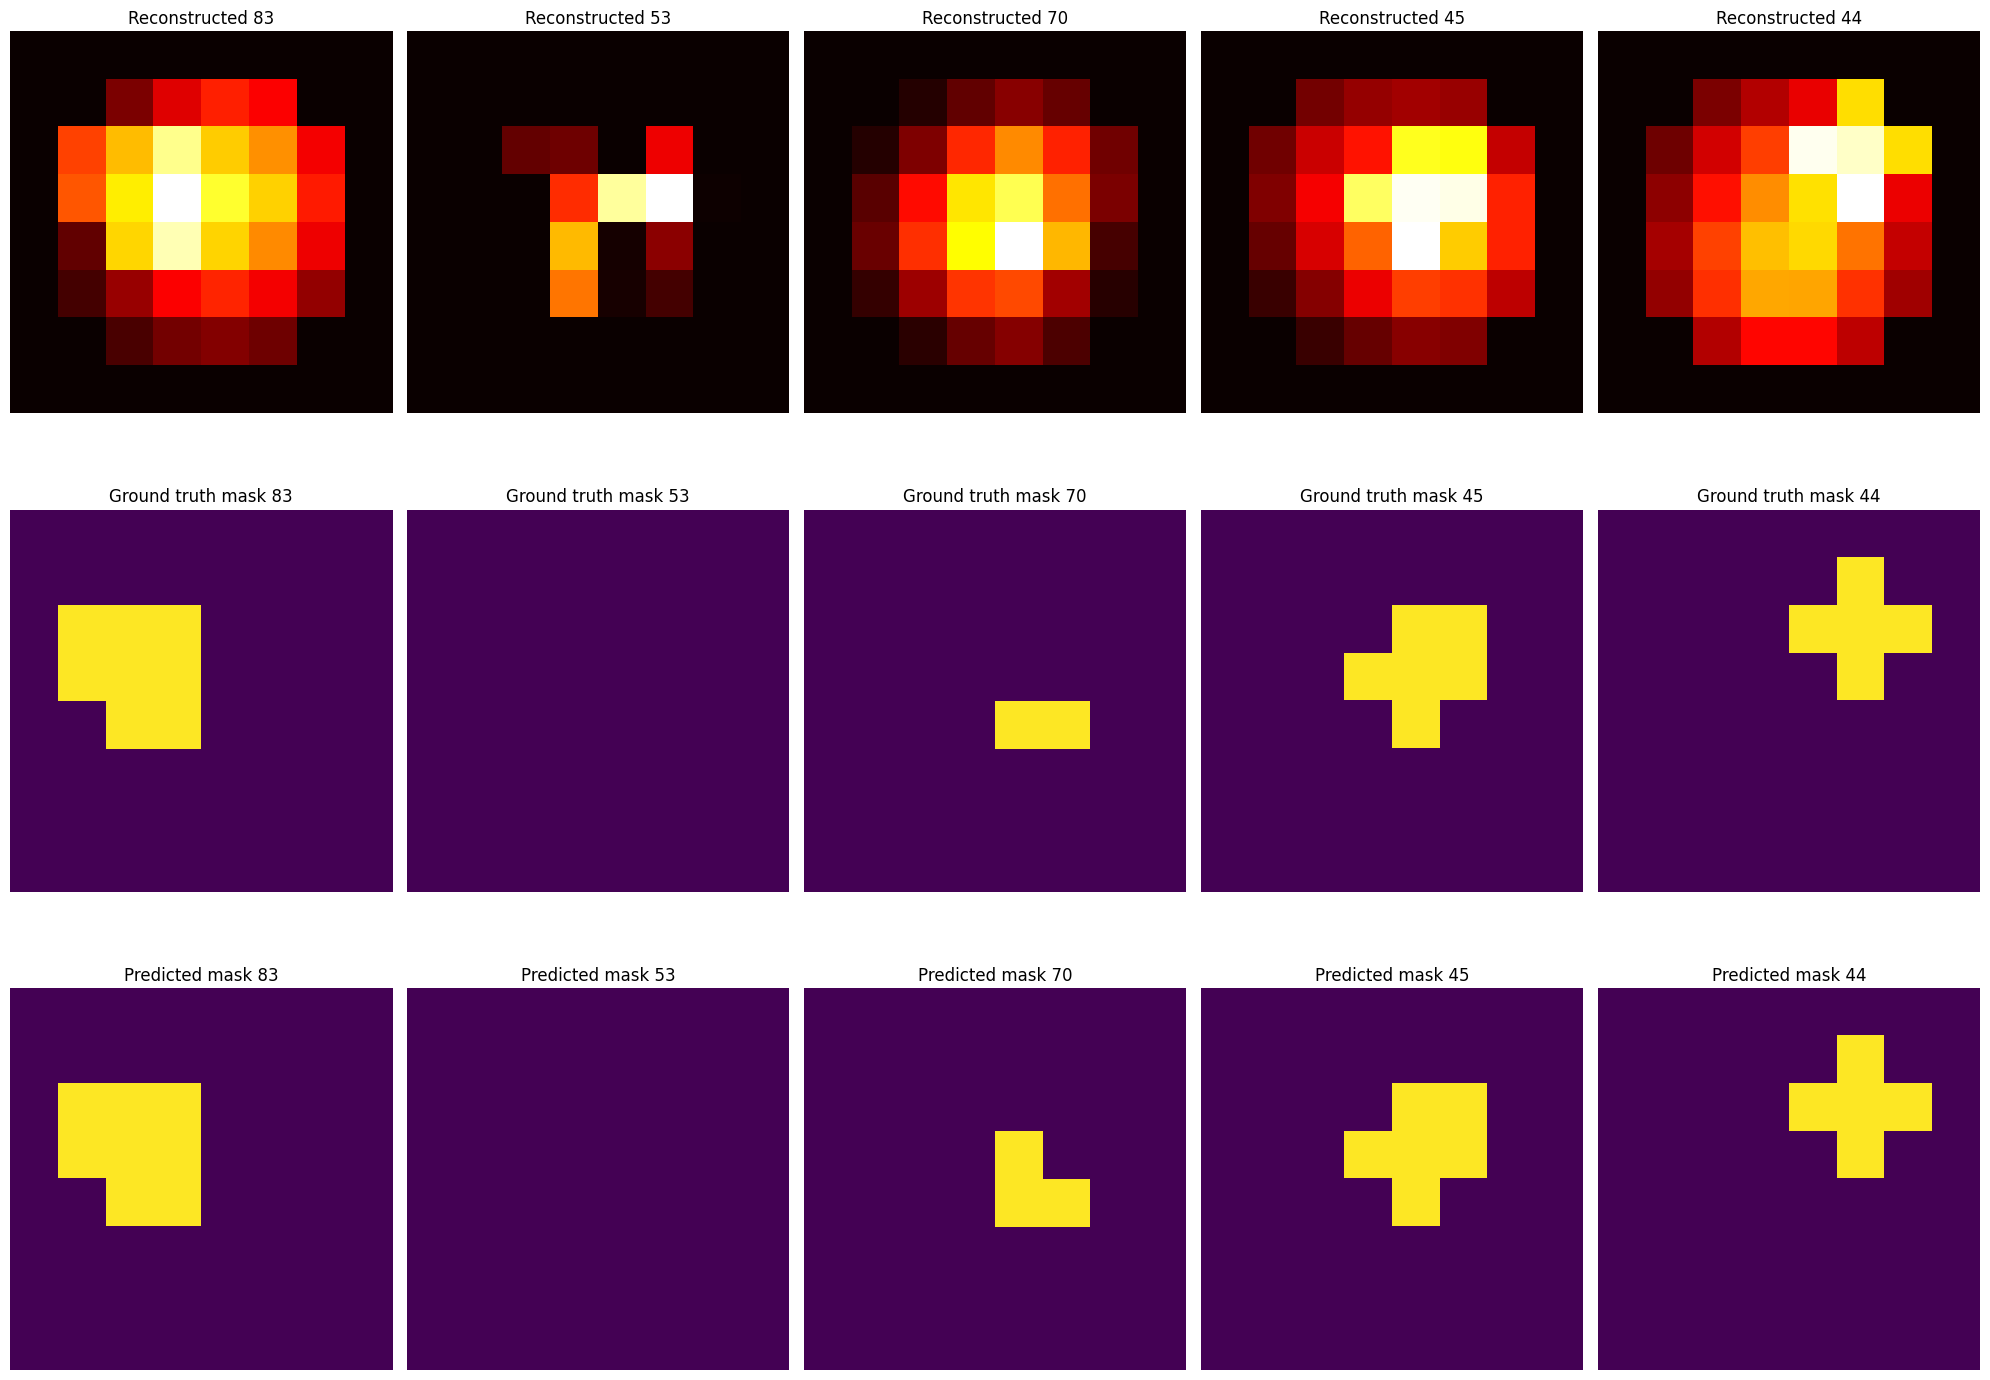

Visualizing U-Net predictions for grid size 32x32.
500
(100, 32, 32, 1)
(100, 32, 32, 1)
4/4 [==============================] - 0s 30ms/step


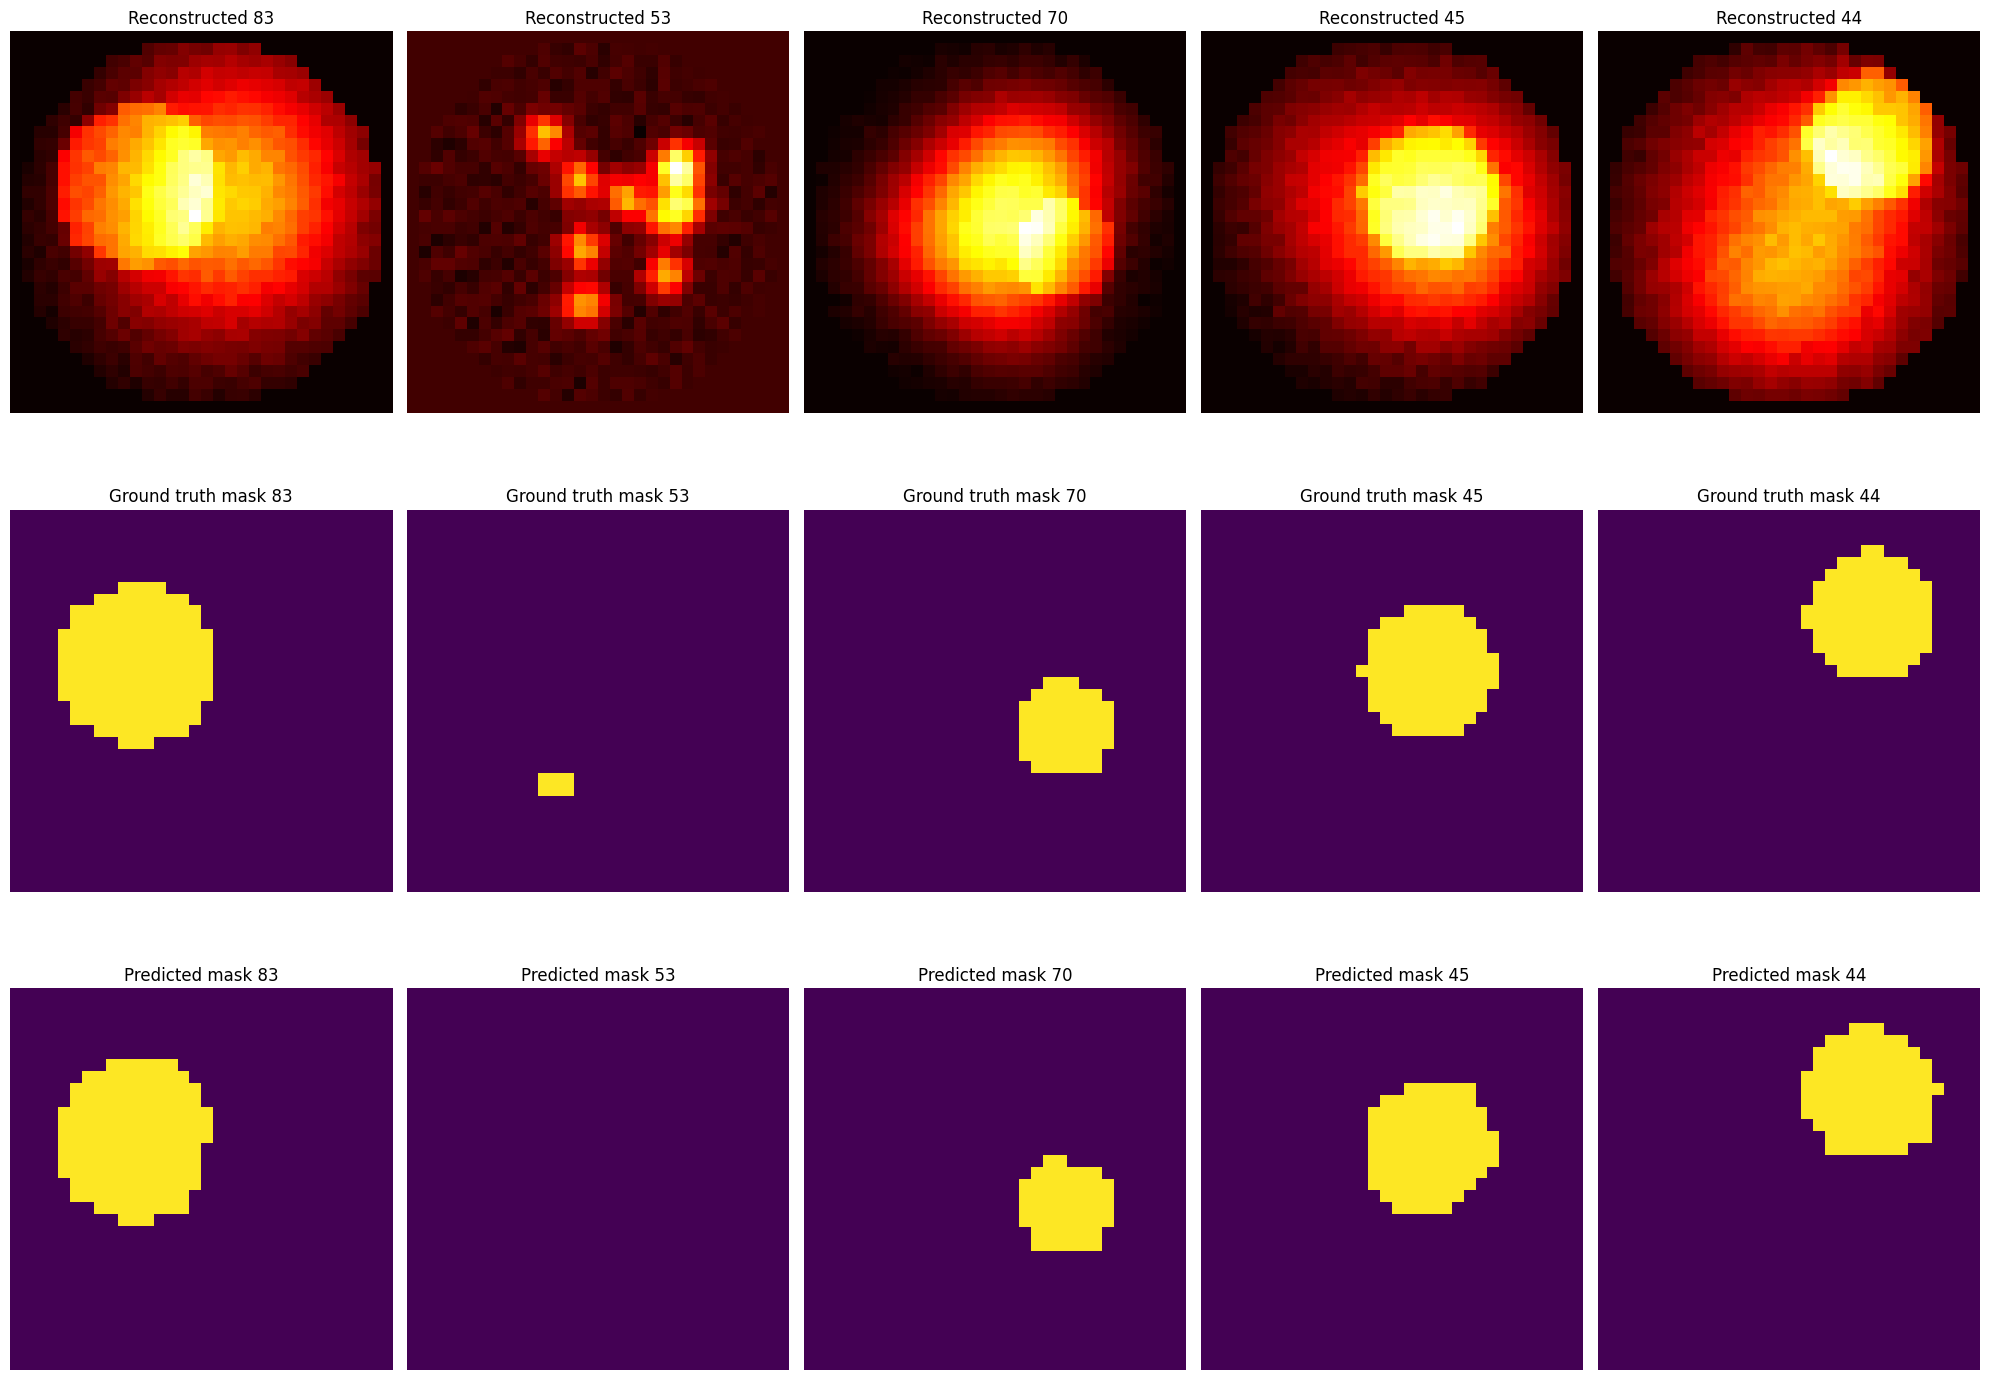

Visualizing U-Net predictions for grid size 64x64.
500
(100, 64, 64, 1)
(100, 64, 64, 1)
4/4 [==============================] - 0s 72ms/step


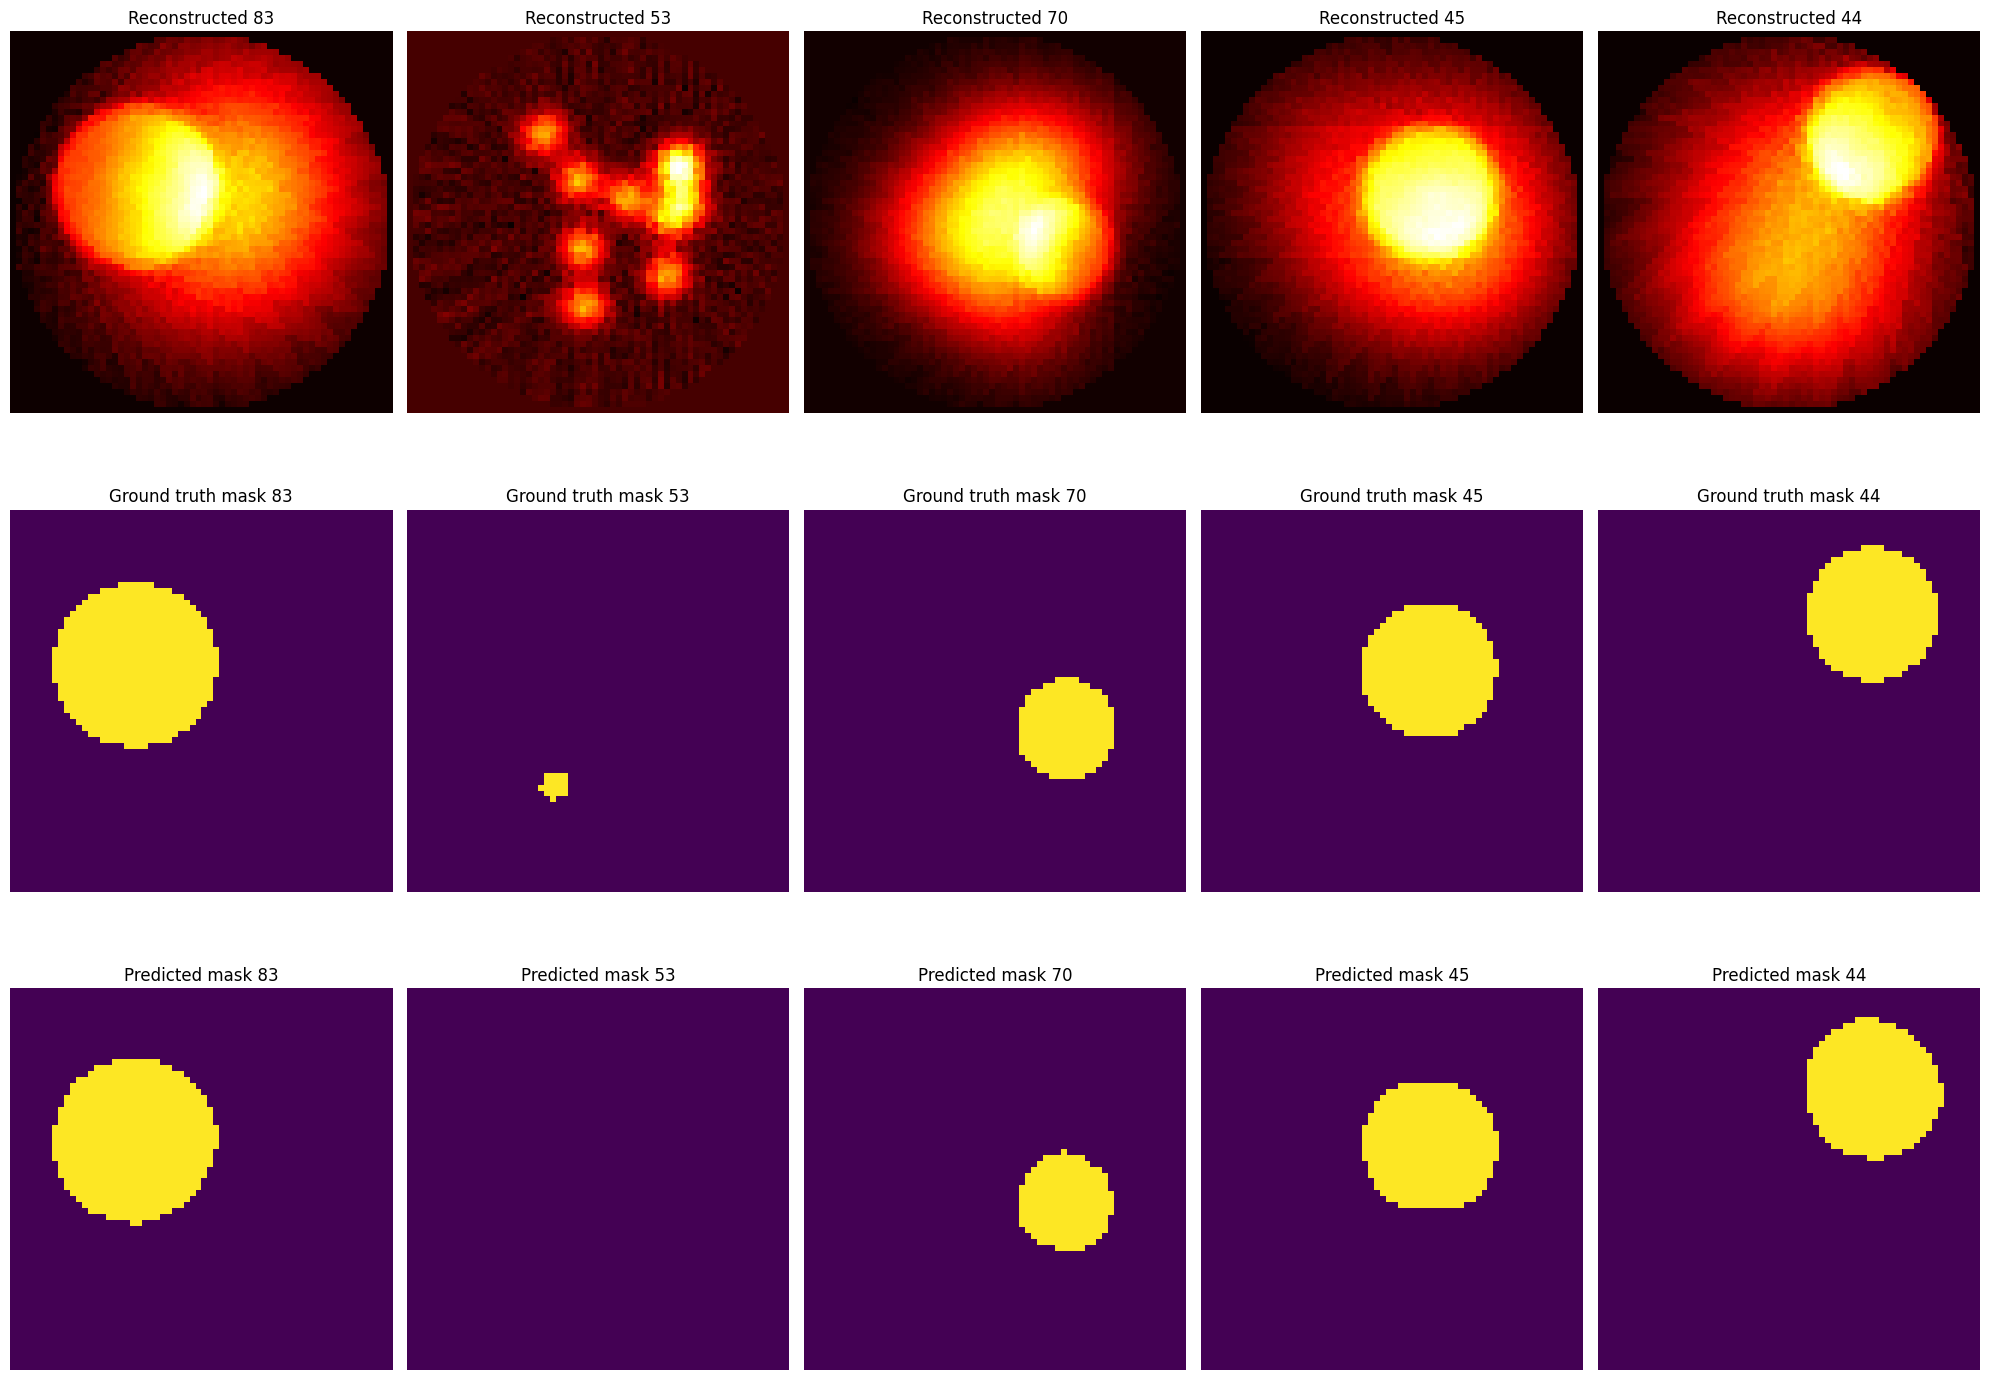

Visualizing U-Net predictions for grid size 128x128.
500
(100, 128, 128, 1)
(100, 128, 128, 1)
4/4 [==============================] - 1s 261ms/step


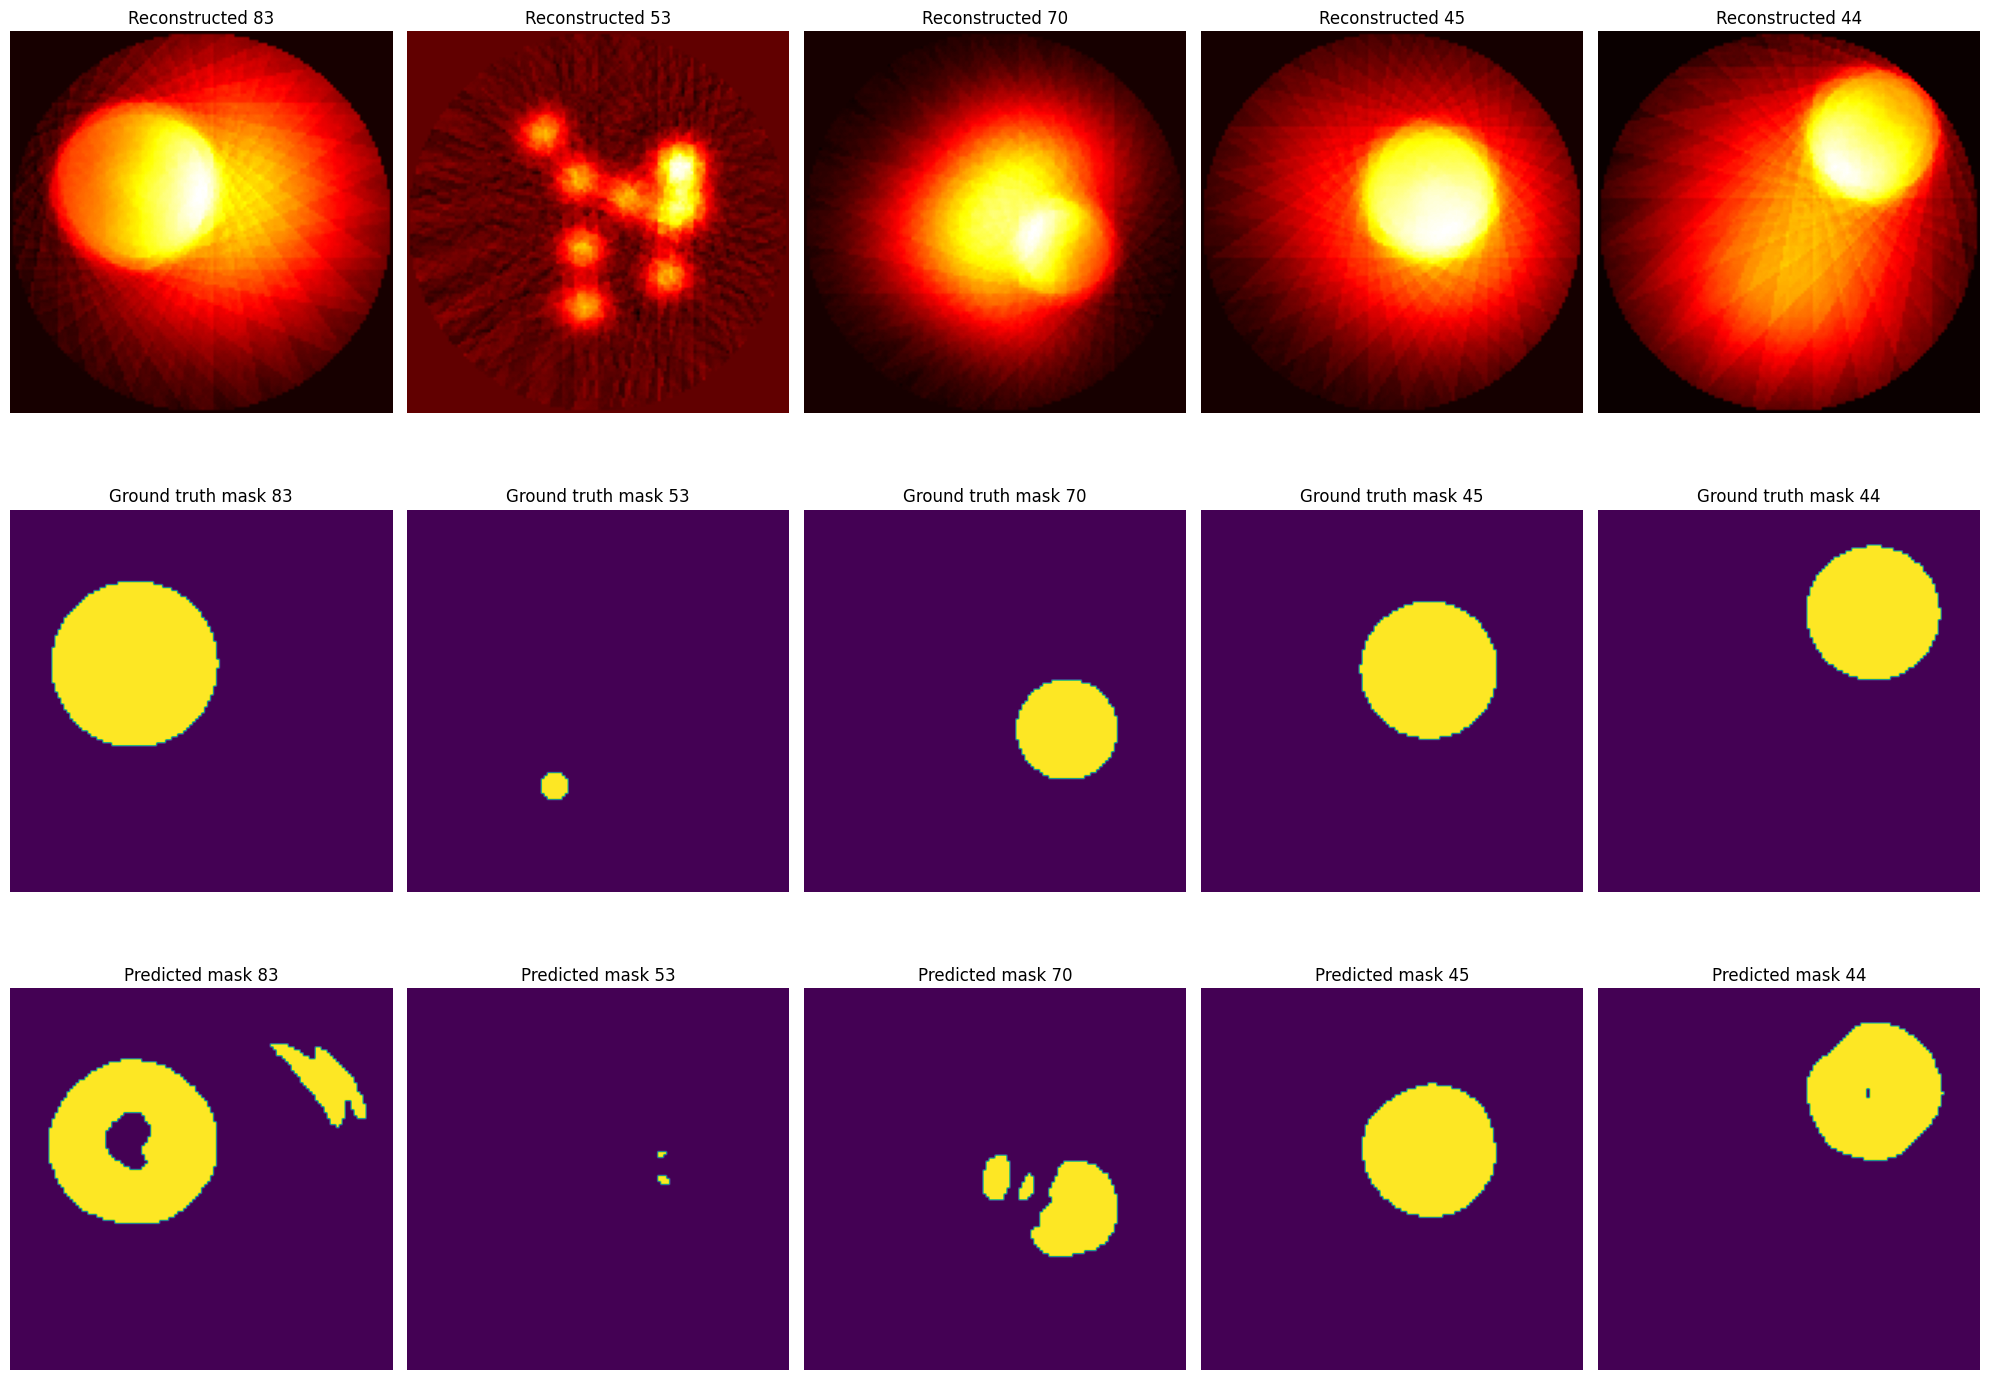

In [16]:
import unet
import systema

for grid_size in grid_size_list:
    print(f"Visualizing U-Net predictions for grid size {grid_size}x{grid_size}.")
    data_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}")
    data = unet.get_data(data_dir, grid_size)
    x_test, x_train, y_test, y_train = unet.data_split(data)
    print(x_test.shape)
    print(y_test.shape)

    model = unet.unet(input_size=(grid_size, grid_size, 1),num_classes=2,base_level_filters=base_level_filters,layers=layers)
    model.load_weights(os.path.join(models_path, f"unet_{grid_size}x{grid_size}.keras"))
    # Predict
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis = 3)
    np.random.seed(42)  # Set seed for reproducibility

    # Visualize random samples
    unet.visualize_random(grid_size, x_test, y_test, pred, num_to_show=5)


500
4/4 [==============================] - 0s 6ms/step
DSC value of 8x8 is [0.61538462 1.         0.85714286 1.         1.         1.
 1.         0.         1.         0.         1.         0.44444444
 1.         0.33333333 1.         1.         1.         0.92307692
 0.         1.         1.         1.         1.         1.
 1.         0.93333333 1.         1.         0.6        1.
 0.66666667 1.         0.8        1.         0.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.57142857 0.         1.         1.         0.90909091 1.
 0.88888889 0.4        0.         1.         0.         1.
 0.94117647 0.57142857 1.         1.         0.         1.
 1.         0.         1.         1.         0.8        1.
 0.         1.         0.         1.         1.         1.
 1.         1.         0.         1.         0.72727273 1.
 1.         0.         1.         0.         1.         1.
 1.         1.         1

/Users/andrews/Desktop/mis_final_proj/unet.py:100: RuntimeWarning: invalid value encountered in divide
  dsc = 2*intersect/union


4/4 [==============================] - 0s 27ms/step
DSC value of 32x32 is [0.99507389 0.98723404 0.96610169 0.         0.98678414 0.
 0.97493036 0.73170732 0.98841699 0.         0.94488189 0.99115044
 0.99470899 0.88888889 0.98333333 1.         0.         0.99122807
 0.         0.         0.7732342  0.98734177 0.96866097 0.96446701
 0.99324324 0.97859327 0.         0.49180328 0.98484848 0.
 0.8988764  0.97922849 0.90909091 0.         0.         0.97280967
 0.         0.99022801 0.97959184 0.         0.98076923 1.
 1.         0.98901099 0.95833333 0.97487437 0.98630137 0.97945205
 0.90322581 0.         0.98395722 0.94017094 0.9569378  0.
 0.99082569 0.96629213 0.89285714 0.984375   0.         0.97014925
 0.95956873 0.95121951 0.9689441  0.92957746 0.         0.91358025
 1.         0.         0.98823529 0.98461538 0.98113208 0.
 0.         0.97311828 0.56716418 0.97905759 0.99099099 0.98837209
 0.93779904 0.30434783 0.         0.97376093 0.98039216 0.97577855
 0.98265896 0.75       0.   

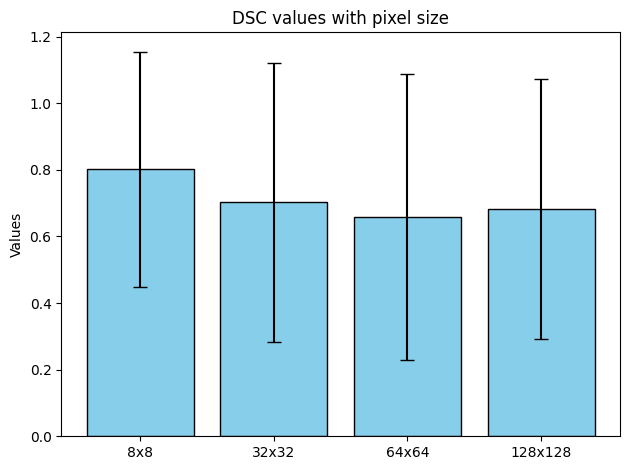

In [18]:
import unet
import systema
import matplotlib.pyplot as plt
import numpy as np

categories = []
values = []
errors = []

for grid_size in grid_size_list:
    data_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}")
    data = unet.get_data(data_dir, grid_size)
    x_test, x_train, y_test, y_train = unet.data_split(data)

    model = unet.unet(input_size=(grid_size, grid_size, 1),num_classes=2,base_level_filters=base_level_filters,layers=layers)
    model.load_weights(os.path.join(models_path, f"unet_{grid_size}x{grid_size}.keras"))
    # Predict
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis = 3)
    np.random.seed(42)  # Set seed for reproducibility

    dsc = unet.dsc(pred, y_test)
    print(f"DSC value of {grid_size}x{grid_size} is {dsc}")
    categories.append(f"{grid_size}x{grid_size}")
    values.append(np.average(dsc))
    errors.append(np.std(dsc))

#plotting DSC values
x_positions = np.arange(len(categories))

plt.bar(x_positions, values, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(x_positions, categories)
plt.ylabel('Values')
plt.title('DSC values with pixel size')


# Display the plot
plt.tight_layout()
plt.show()

 



    



    

500
4/4 [==============================] - 0s 5ms/step
(100, 8, 8)
500
4/4 [==============================] - 0s 26ms/step
(100, 32, 32)
500
4/4 [==============================] - 0s 68ms/step
(100, 64, 64)
500
4/4 [==============================] - 1s 269ms/step
(100, 128, 128)


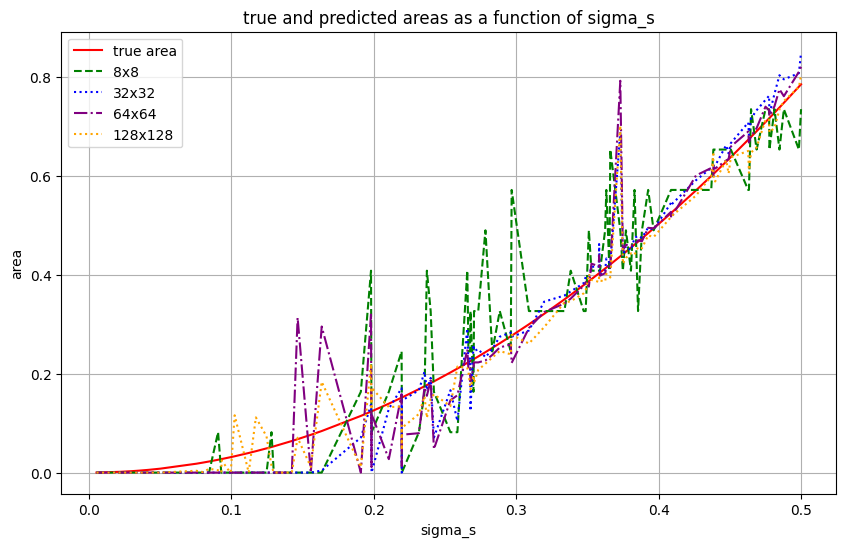

In [28]:
import unet
import systema
import matplotlib.pyplot as plt
import numpy as np
import datagen

pred_area_8 = []
pred_area_32 = []
pred_area_64 = []
pred_area_128 = []

for grid_size in grid_size_list:
    data_dir = os.path.join(output_dir, f"{grid_size}x{grid_size}")
    sigma_dir = os.path.join(data_dir, "sigma_s")
    data = unet.get_data(data_dir, grid_size)
    x_test, x_train, y_test, y_train = unet.data_split(data)
    sigmas = datagen.get_data_contents_from_folder(sigma_dir)
    sigmas = sigmas[:x_test.shape[0]]

    model = unet.unet(input_size=(grid_size, grid_size, 1),num_classes=2,base_level_filters=base_level_filters,layers=layers)
    model.load_weights(os.path.join(models_path, f"unet_{grid_size}x{grid_size}.keras"))
    # Predict
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis = 3)

    #print(f"sigmas for size {grid_size} are {sigmas}")
    #print(f"true signal areas for size {grid_size} is {true_area}")
    pixel_area = (2 / (grid_size - 1))**2  # Area of each pixel
    pixel_count = np.sum(pred, axis = (1, 2))
    pred_area = pixel_area * pixel_count
    print(pred.shape)
    if grid_size == 8:
        pred_area_8 = np.append(pred_area_8, pred_area)
    elif grid_size == 32:
        pred_area_32 = np.append(pred_area_32, pred_area)
    elif grid_size == 64:
        pred_area_64 = np.append(pred_area_64, pred_area)
    elif grid_size == 128:
        pred_area_128 = np.append(pred_area_128, pred_area)
    #print(pred_area.shape)

true_area = np.pi * (np.power(sigmas,2))

#sorting here
data = np.array([sigmas, true_area, pred_area_8, pred_area_32, pred_area_64, pred_area_128])
sorted_data = data[:, data[0].argsort()]
sigmas_sorted = sorted_data[0]
true_area_sorted = sorted_data[1]
pred_area_8_sorted = sorted_data[2]
pred_area_32_sorted = sorted_data[3]
pred_area_64_sorted = sorted_data[4]
pred_area_128_sorted = sorted_data[5]

# Example: Independent variable x
x = sigmas_sorted

# Dependent variables y1, y2, y3, and y4 (example functions of x)
y1 = true_area_sorted
y2 = pred_area_8_sorted
y3 = pred_area_32_sorted # Note: tan(x) can have large values, so we might want to limit the range
y4 = pred_area_64_sorted
y5 = pred_area_128_sorted





# Plot all four functions
plt.figure(figsize=(10, 6))

# Plot y1, y2, y3, y4 against x
plt.plot(x, y1, label='true area', color='red')
plt.plot(x, y2, label='8x8', color='green', linestyle='dashed')
plt.plot(x, y3, label='32x32', color='blue', linestyle='dotted')
plt.plot(x, y4, label='64x64', color='purple', linestyle='dashdot')
plt.plot(x, y5, label='128x128', color='orange', linestyle='dotted')

# Add title and labels
plt.title('true and predicted areas as a function of sigma_s')
plt.xlabel('sigma_s')
plt.ylabel('area')

# Add grid
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()
